In [91]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [92]:
import json
from pathlib import Path
import numpy as np
import pandas as pd
import html
import re
from fastai.text import *
from tqdm import tqdm
from sklearn import model_selection

In [93]:
pwd

'C:\\Users\\PC\\Projects\\fastai\\courses\\dl1\\ULMFiT-Filipino'

# Data Preparation

In [94]:
BOS = 'xbos'  # beginning-of-sentence tag
FLD = 'xfld'  # data field tag

LANG = 'tagalog'
PATH_EXTRACT = Path(f'tagalog/')
PATH_TMP = Path(f'tmp/')

In [95]:
LANG_FILENAMES = [str(f) for f in PATH_EXTRACT.rglob("*/wiki_*")]
print(len(LANG_FILENAMES))
LANG_FILENAMES[0:5]

53


['tagalog\\wiki\\wiki_00',
 'tagalog\\wiki\\wiki_01',
 'tagalog\\wiki\\wiki_02',
 'tagalog\\wiki\\wiki_03',
 'tagalog\\wiki\\wiki_04']

In [96]:
LANG_TEXT = []
for fn in tqdm(LANG_FILENAMES):
    for line in open(fn, encoding='utf8'):
        LANG_TEXT.append(json.loads(line))
        
LANG_TEXT = pd.DataFrame(LANG_TEXT)


100%|██████████████████████████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 71.42it/s]

In [97]:
LANG_TEXT.head()

,id,text,title,url
0,1,Unang Pahina\n,Unang Pahina,https://tl.wikipedia.org/wiki?curid=1
1,5,Wikipedia\n\nAng Wikipedia ay isang ensikloped...,Wikipedia,https://tl.wikipedia.org/wiki?curid=5
2,7,Wiki\n\nAng wiki ay isang uri ng websayt na pi...,Wiki,https://tl.wikipedia.org/wiki?curid=7
3,582,"Pilipinas\n\nAng Pilipinas, opisyal na Republi...",Pilipinas,https://tl.wikipedia.org/wiki?curid=582
4,585,Maynila\n\nAng Lungsod ng Maynila (Opisyal: Ci...,Maynila,https://tl.wikipedia.org/wiki?curid=585


In [98]:
# Getting rid of the title name in the text field
def split_title_from_text(text):
    words = text.split("\n\n")
    if len(words) >= 2:
        return ''.join(words[1:])
    else:
        return ''.join(words)
    
LANG_TEXT['text'] = LANG_TEXT['text'].apply(lambda x: split_title_from_text(x))

In [99]:
LANG_TEXT.head()

,id,text,title,url
0,1,Unang Pahina\n,Unang Pahina,https://tl.wikipedia.org/wiki?curid=1
1,5,Ang Wikipedia ay isang ensiklopedya na may bas...,Wikipedia,https://tl.wikipedia.org/wiki?curid=5
2,7,Ang wiki ay isang uri ng websayt na pinapahint...,Wiki,https://tl.wikipedia.org/wiki?curid=7
3,582,"Ang Pilipinas, opisyal na Republika ng Pilipin...",Pilipinas,https://tl.wikipedia.org/wiki?curid=582
4,585,Ang Lungsod ng Maynila (Opisyal: City of Manil...,Maynila,https://tl.wikipedia.org/wiki?curid=585


In [100]:
LANG_TEXT.shape

(106124, 4)

Sorting the articles by length and keeping the first million (this is actually not necessary for the Tagalog wiki since it has less than 100k articles in 2018).

In [101]:
LANG_TEXT = LANG_TEXT.assign(length = 0)
LANG_TEXT.columns = ['id', 'text', 'title', 'url', 'length']
LANG_TEXT = LANG_TEXT.assign(labels = 0).pipe(lambda x: x[['labels', 'text', 'length']])

In [102]:
LANG_TEXT.head()

,labels,text,length
0,0,Unang Pahina\n,0
1,0,Ang Wikipedia ay isang ensiklopedya na may bas...,0
2,0,Ang wiki ay isang uri ng websayt na pinapahint...,0
3,0,"Ang Pilipinas, opisyal na Republika ng Pilipin...",0
4,0,Ang Lungsod ng Maynila (Opisyal: City of Manil...,0


In [103]:
LANG_TEXT['length'] = LANG_TEXT['text'].str.len()
LANG_TEXT = LANG_TEXT.sort_values(by=['length'], ascending=False)

In [104]:
LANG_TEXT.head()

,labels,text,length
20794,0,Ito ay ang talaan ng mga kabanata ng Noli Me T...,183621
4813,0,Ang Ebolusyon ang pagbabago sa mga namamanang ...,110764
82737,0,"100,000 Digits of PiPi Logo\n3.141592653589793...",101311
727,0,"Ang Nagkakaisang Kaharian, opisyal na Nagkakai...",96674
2134,0,Ang Simbahang Katolika Romana o Simbahang Kato...,94932


In [105]:
len(LANG_TEXT)

106124

In [106]:
LANG_TEXT.to_csv(f"wiki_{LANG}_corpus.csv", header=False, index=False)

In [107]:
LANG_TEXT = pd.read_csv(f"wiki_{LANG}_corpus.csv")

In [108]:
len(LANG_TEXT)

106123

In [109]:
LANG_TEXT.columns = ['labels', 'text', 'length']
LANG_TEXT = LANG_TEXT[LANG_TEXT['length'] > 10]
# LANG_TEXT = LANG_TEXT.drop(['length'], axis=1)

In [110]:
LANG_TEXT.head()

,labels,text,length
0,0,Ang Ebolusyon ang pagbabago sa mga namamanang ...,110764
1,0,"100,000 Digits of PiPi Logo\r\n3.1415926535897...",101311
2,0,"Ang Nagkakaisang Kaharian, opisyal na Nagkakai...",96674
3,0,Ang Simbahang Katolika Romana o Simbahang Kato...,94932
4,0,Mustafa Kemal Atatürk (; 19 May 1881 – 10 Nov...,90134


In [111]:
len(LANG_TEXT)

103822

## Some statistics of Indonesia Wikipedia

### Number of documents

In [112]:
print(LANG_TEXT['text'][:5])
LANG_TEXT.shape

0    Ang Ebolusyon ang pagbabago sa mga namamanang ...
1    100,000 Digits of PiPi Logo\r\n3.1415926535897...
2    Ang Nagkakaisang Kaharian, opisyal na Nagkakai...
3    Ang Simbahang Katolika Romana o Simbahang Kato...
4    Mustafa Kemal Atatürk (; 19 May 1881  – 10 Nov...
Name: text, dtype: object


(103822, 3)

### Number of words in all the documents

In [113]:
def x_split(x):
    l = 0
    try:
        l = len(x.split(" "))
    except AttributeError:
        print(x)
    return l

LANG_TEXT['text'].apply(lambda x: x_split(x)).sum()    
#LANG_TEXT['text'].apply(lambda x: len(x.split(" "))).sum()

6136315

### Number of unique tokens across documents

In [114]:
len(set(''.join(LANG_TEXT['text'].values).split(" ")))

548210

## Clear plain text

In [115]:
re1 = re.compile(r'  +')

def fixup(x):
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x))

## Tokenize

In [116]:
def get_texts(df, n_lbls=1):
    labels = df.iloc[:,range(n_lbls)].values.astype(np.int64)
    texts = f'\n{BOS} {FLD} 1 ' + df[n_lbls].astype(str)
    for i in range(n_lbls+1, len(df.columns)): 
        texts += f' {FLD} {i-n_lbls} ' + df[i].astype(str)
    texts = texts.apply(fixup).values.astype(str)
    tok = Tokenizer(n_cpus=1).process_all(texts) # splits the list into sublists for processing by each core
    # Lower and upper case is inside the tokenizer
    return tok, list(labels)

def get_all(df, n_lbls):
    tok, labels = [], []
    for i, r in enumerate(df):
        print(i)
        #pdb.set_trace()
        tok_, labels_ = get_texts(r, n_lbls)
        tok += tok_;
        labels += labels_
    return tok, labels

## Create validation set

In [29]:
#LANG_TEXT = pd.read_csv(f"{PATH_ROOT}/wiki_{LANG}_corpus.csv")
#LANG_TEXT.columns = ['labels', 'text']

In [30]:
print(LANG_TEXT.head())
LANG_TEXT.shape

   labels                                               text  length
0       0  Ang Ebolusyon ang pagbabago sa mga namamanang ...  110764
1       0  100,000 Digits of PiPi Logo\r\n3.1415926535897...  101311
2       0  Ang Nagkakaisang Kaharian, opisyal na Nagkakai...   96674
3       0  Ang Simbahang Katolika Romana o Simbahang Kato...   94932
4       0  Mustafa Kemal Atatürk (; 19 May 1881  – 10 Nov...   90134


(103822, 3)

In [31]:
trn_texts,val_texts = model_selection.train_test_split(
    LANG_TEXT, test_size=0.1, random_state=427) # split the data into train and validation sets

In [32]:
len(trn_texts), len(val_texts)

(93439, 10383)

In [33]:
np.random.seed(427)
trn_idx = np.random.permutation(len(trn_texts)) # generate a random ordering
val_idx = np.random.permutation(len(val_texts))

df_trn = trn_texts.iloc[trn_idx,:] # sort things randomly
df_val = val_texts.iloc[val_idx,:] # sort things randomly

df_trn.columns = ['labels', 'text', 'length']
df_val.columns = ['labels', 'text', 'length']

df_trn.to_csv(f"wiki_{LANG}_train.csv", header=False, index=False)
df_val.to_csv(f"wiki_{LANG}_test.csv", header=False, index=False) # saving the data in our new format to disk

In [34]:
chunksize = 5000
df_trn = pd.read_csv(f"wiki_{LANG}_train.csv", header=None, chunksize=chunksize)
df_val = pd.read_csv(f"wiki_{LANG}_test.csv", header=None, chunksize=chunksize)

In [35]:
wiki_tok_trn, wiki_trn_labels = get_all(df_trn, 1)
wiki_tok_val, wiki_val_labels = get_all(df_val, 1)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
0
1
2


In [36]:
# create a tmp directory to store the upcoming numpy arrays
(PATH_TMP).mkdir(exist_ok=True)

# save the train and validation tokens in the tmp directories
np.save(PATH_TMP/'wiki_tok_trn.npy', wiki_tok_trn)
np.save(PATH_TMP/'wiki_tok_val.npy', wiki_tok_val)

In [37]:
wiki_tok_trn = np.load(PATH_TMP/'wiki_tok_trn.npy')
wiki_tok_val = np.load(PATH_TMP/'wiki_tok_val.npy')

In [42]:
print("Trn:", wiki_tok_trn[:3], "\n")

Trn: [list(['\n', 'xbos', 'xfld', '1', 'ang', 'muscat', 'ay', 'ang', 'kabisera', 'ng', 'bansang', 'oman', '.', '\r\r\n ', 'xfld', '1', '44'])
 list(['\n', 'xbos', 'xfld', '1', 'taliabo', 'ay', 'isang', 'wikang', 'sinasalita', 'sa', 'indonesia.[[kaurian', ':', 'mga', 'wika', 'ng', 'indonesia', 'xfld', '1', '79'])
 list(['\n', 'xbos', 'xfld', '1', 'sa', 'mga', 'larangan', 'ng', 'sikolohiya', 'at', 'sikyatriya', ',', 'ang', 'depresyon', 'na', 'kilala', 'sa', 'ingles', 'bilang', 'major', 'depressive', 'disorder', '(', 'xxup', 'mdd', ')', ',', 'recurrent', 'depressive', 'disorder', ',', 'clinical', 'depression', ',', 'major', 'depression', ',', 'unipolar', 'depression', ',', 'o', 'unipolar', 'disorder', 'ay', 'isang', 'sakit', 'sa', 'pag', '-', 'iisip', 'na', 'inilalarawan', 'ng', 'malawakang', 'mababang', 'mood', 'na', 'sinamahan', 'ng', 'mababang', 'pagtingin', 'sa', 'sarili', '(', 'nawala', 'ang', 'pagpapahalaga', 'sa', 'sarili', ')', ',', 'kawalan', 'ng', 'interes', 'o', 'kasiyahan', 's

In [45]:
# Get the Counter object from all the splitted files.
# Identify the most common tokens
from collections import Counter
freq = Counter(p for o in wiki_tok_trn for p in o) 
freqs = pd.DataFrame.from_dict(freq, orient="index")
freqs.sort_values(0, ascending=False).head(25)

,0
ng,376882
sa,370400
.,290593
ang,281417
",",245144
na,244919
ay,199915
mga,191252
1,189602
xfld,186878


In [46]:
# Sanity check
len([p for o in wiki_tok_trn for p in o])

7544349

In [47]:
cnt = []
for i in range(49):
    row_cnt = freqs[freqs[0]>=i+1].shape[0]
    cnt.append(row_cnt)

Populating the interactive namespace from numpy and matplotlib


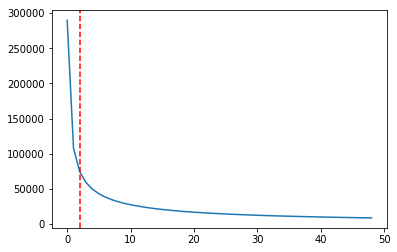

In [51]:
%pylab inline
plt.plot(cnt)
plt.axvline(x=2, color="red", linestyle="--")

## Numericalize the text

In [52]:
# Truncating our vocab to ignore the rare words
max_vocab = 60000
min_freq = 5

wiki_itos = [o for o,c in freq.most_common(max_vocab) if c>min_freq] # getting rid of the rare words
wiki_itos.insert(0, '_pad_') # 
wiki_itos.insert(0, '_unk_') # wiki_itos is the list of all the strings in the vocab

In [54]:
import collections
# creating a index-key dictionary for our vocabulary
wiki_stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(wiki_itos)})
len(wiki_itos)

43006

In [55]:
# creating a index representation for our train and validation dataset
wiki_trn_lm = np.array([[wiki_stoi[o] for o in p] for p in wiki_tok_trn])
wiki_val_lm = np.array([[wiki_stoi[o] for o in p] for p in wiki_tok_val])

In [58]:
import pickle
# saving our indexed representation of our dataset to disk
# we also save the index-word mapping to retrieve the complete text representation from these numpy arrays
np.save(PATH_TMP/'wiki_trn_ids.npy', wiki_trn_lm)
np.save(PATH_TMP/'wiki_val_ids.npy', wiki_val_lm)
pickle.dump(wiki_itos, open(f'wiki_{LANG}_itos.pkl', 'wb'))

In [5]:
# Loading the indexed representation of our dataset from disk
# we also load the index-word mapping to to help us convert the indexes to word datasets, if need be.
trn_lm = np.load(PATH_TMP/'wiki_trn_ids.npy')
val_lm = np.load(PATH_TMP/'wiki_val_ids.npy')
wiki_itos = pickle.load(open(f'wiki_{LANG}_itos.pkl', 'rb'))

In [6]:
# checking vocabulary size
vs=len(wiki_itos)
word_count = 0
for i in trn_lm:
    word_count += len(trn_lm[i])

In [7]:
print(f'vocabulary size: {vs}, #articles: {len(trn_lm)}, #words: {word_count}')

vocabulary size: 43006, #articles: 93439, #words: 7544349


# Model Setup

# Language Model

In [11]:
from functools import partial
import torch.optim as optim

em_sz = 400  # size of each embedding vector
nh = 1150    # number of hidden activations per layer
nl = 3       # number of layers

wd = 1e-7
bptt = 70
bs = 64
# opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
opt_fn = partial(optim.SGD, momentum=0.9)
weight_factor = 0.3

In [12]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*weight_factor

In [13]:
%time

trn_dl = LanguageModelLoader(np.concatenate(trn_lm), bs, bptt)
val_dl = LanguageModelLoader(np.concatenate(val_lm), bs, bptt)
md = LanguageModelData('.', 1, vs, trn_dl, val_dl, bs=bs, bptt=bptt)

Wall time: 0 ns


In [14]:
learner= md.get_model(opt_fn, em_sz, nh, nl, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

learner.metrics = [accuracy]
learner.clip = 0.2
learner.unfreeze()

In [15]:
# AWD-LSTM network
learner.summary

<bound method Learner.summary of SequentialRNN(
  (0): RNN_Encoder(
    (encoder): Embedding(43006, 400, padding_idx=1)
    (encoder_with_dropout): EmbeddingDropout(
      (embed): Embedding(43006, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDrop(
        (module): LSTM(400, 1150)
      )
      (1): WeightDrop(
        (module): LSTM(1150, 1150)
      )
      (2): WeightDrop(
        (module): LSTM(1150, 400)
      )
    )
    (dropouti): LockedDropout()
    (dropouths): ModuleList(
      (0): LockedDropout()
      (1): LockedDropout()
      (2): LockedDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=43006, bias=False)
    (dropout): LockedDropout()
  )
)>

In [16]:
learner.lr_find2(num_it=1000)

  0%|                                                                                         | 0/1683 [00:00<?, ?it/s]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  0%|                                                                      | 1/1683 [00:01<48:11,  1.72s/it, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  0%|                                                                      | 2/1683 [00:02<36:58,  1.32s/it, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  0%|                                                                      | 3/1683 [00:02<28:36,  1.02s/it, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  0%|▏                                                                     | 4/1683 [00:02<23:10,  1.21it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  0%|▏                                                                     | 5/1683 [00:03<19:22,  1.44it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  0%|▏                                                                     | 6/1683 [00:03<16:10,  1.73it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  0%|▎                                                                     | 7/1683 [00:03<14:37,  1.91it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  0%|▎                                                                     | 8/1683 [00:04<13:28,  2.07it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|▎                                                                     | 9/1683 [00:04<12:33,  2.22it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|▍                                                                    | 10/1683 [00:04<10:59,  2.54it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|▍                                                                    | 11/1683 [00:05<11:00,  2.53it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|▍                                                                    | 12/1683 [00:05<10:51,  2.56it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|▌                                                                    | 13/1683 [00:06<10:25,  2.67it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|▌                                                                    | 14/1683 [00:06<10:19,  2.69it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|▌                                                                    | 15/1683 [00:06<10:12,  2.72it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|▋                                                                    | 16/1683 [00:07<10:40,  2.60it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|▋                                                                    | 17/1683 [00:07<10:37,  2.61it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|▋                                                                    | 18/1683 [00:07<09:45,  2.84it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|▊                                                                    | 19/1683 [00:08<09:46,  2.84it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|▊                                                                    | 20/1683 [00:08<10:04,  2.75it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|▊                                                                    | 21/1683 [00:08<10:16,  2.70it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|▉                                                                    | 22/1683 [00:09<10:15,  2.70it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|▉                                                                    | 23/1683 [00:09<10:06,  2.74it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|▉                                                                    | 24/1683 [00:10<10:22,  2.67it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  1%|█                                                                    | 25/1683 [00:10<10:30,  2.63it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|█                                                                    | 26/1683 [00:10<10:39,  2.59it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|█                                                                    | 27/1683 [00:11<10:40,  2.59it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|█▏                                                                   | 28/1683 [00:11<10:29,  2.63it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|█▏                                                                   | 29/1683 [00:11<10:15,  2.69it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|█▏                                                                   | 30/1683 [00:12<10:35,  2.60it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|█▎                                                                   | 31/1683 [00:12<10:35,  2.60it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|█▎                                                                   | 32/1683 [00:13<10:31,  2.62it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|█▎                                                                   | 33/1683 [00:13<10:39,  2.58it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|█▍                                                                   | 34/1683 [00:13<10:40,  2.58it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|█▍                                                                   | 35/1683 [00:14<10:02,  2.73it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|█▍                                                                   | 36/1683 [00:14<10:09,  2.70it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|█▌                                                                   | 37/1683 [00:15<10:21,  2.65it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|█▌                                                                   | 38/1683 [00:15<09:58,  2.75it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|█▌                                                                   | 39/1683 [00:15<10:10,  2.69it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|█▋                                                                   | 40/1683 [00:16<10:15,  2.67it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|█▋                                                                   | 41/1683 [00:16<10:24,  2.63it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  2%|█▋                                                                   | 42/1683 [00:16<10:20,  2.65it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|█▊                                                                   | 43/1683 [00:17<10:37,  2.57it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|█▊                                                                   | 44/1683 [00:17<10:38,  2.57it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|█▊                                                                   | 45/1683 [00:18<10:43,  2.55it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|█▉                                                                   | 46/1683 [00:18<10:40,  2.56it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|█▉                                                                   | 47/1683 [00:18<10:43,  2.54it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|█▉                                                                   | 48/1683 [00:19<09:27,  2.88it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|██                                                                   | 49/1683 [00:19<09:30,  2.87it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|██                                                                   | 50/1683 [00:19<10:00,  2.72it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|██                                                                   | 51/1683 [00:20<10:06,  2.69it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|██▏                                                                  | 52/1683 [00:20<10:07,  2.68it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|██▏                                                                  | 53/1683 [00:21<10:25,  2.61it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|██▏                                                                  | 54/1683 [00:21<10:28,  2.59it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|██▎                                                                  | 55/1683 [00:21<09:22,  2.89it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|██▎                                                                  | 56/1683 [00:22<09:47,  2.77it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|██▎                                                                  | 57/1683 [00:22<10:15,  2.64it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  3%|██▍                                                                  | 58/1683 [00:22<10:21,  2.61it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|██▍                                                                  | 59/1683 [00:23<10:19,  2.62it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|██▍                                                                  | 60/1683 [00:23<10:39,  2.54it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|██▌                                                                  | 61/1683 [00:24<10:30,  2.57it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|██▌                                                                  | 62/1683 [00:24<10:13,  2.64it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|██▌                                                                  | 63/1683 [00:24<10:12,  2.64it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|██▌                                                                  | 64/1683 [00:25<10:12,  2.64it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|██▋                                                                  | 65/1683 [00:25<10:07,  2.67it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|██▋                                                                  | 66/1683 [00:25<09:09,  2.94it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|██▋                                                                  | 67/1683 [00:26<09:29,  2.84it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|██▊                                                                  | 68/1683 [00:26<09:48,  2.75it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|██▊                                                                  | 69/1683 [00:26<09:43,  2.77it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|██▊                                                                  | 70/1683 [00:27<10:09,  2.65it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|██▉                                                                  | 71/1683 [00:27<10:21,  2.59it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|██▉                                                                  | 72/1683 [00:28<10:46,  2.49it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|██▉                                                                  | 73/1683 [00:28<10:36,  2.53it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|███                                                                  | 74/1683 [00:28<09:41,  2.77it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  4%|███                                                                  | 75/1683 [00:29<09:47,  2.74it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|███                                                                  | 76/1683 [00:29<09:35,  2.79it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|███▏                                                                 | 77/1683 [00:29<09:46,  2.74it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|███▏                                                                 | 78/1683 [00:30<10:00,  2.67it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|███▏                                                                 | 79/1683 [00:30<10:22,  2.58it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|███▎                                                                 | 80/1683 [00:31<10:33,  2.53it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|███▎                                                                 | 81/1683 [00:31<10:25,  2.56it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|███▎                                                                 | 82/1683 [00:31<10:26,  2.55it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|███▍                                                                 | 83/1683 [00:32<10:19,  2.58it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|███▍                                                                 | 84/1683 [00:32<10:42,  2.49it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|███▍                                                                 | 85/1683 [00:33<10:39,  2.50it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|███▌                                                                 | 86/1683 [00:33<10:43,  2.48it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|███▌                                                                 | 87/1683 [00:34<10:53,  2.44it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|███▌                                                                 | 88/1683 [00:34<10:50,  2.45it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|███▋                                                                 | 89/1683 [00:34<10:44,  2.47it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|███▋                                                                 | 90/1683 [00:35<10:41,  2.48it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|███▋                                                                 | 91/1683 [00:35<10:43,  2.47it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  5%|███▊                                                                 | 92/1683 [00:36<10:47,  2.46it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|███▊                                                                 | 93/1683 [00:36<10:53,  2.43it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|███▊                                                                 | 94/1683 [00:36<10:52,  2.44it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|███▉                                                                 | 95/1683 [00:37<10:39,  2.48it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|███▉                                                                 | 96/1683 [00:37<10:51,  2.44it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|███▉                                                                 | 97/1683 [00:37<09:39,  2.74it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|████                                                                 | 98/1683 [00:38<09:56,  2.66it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|████                                                                 | 99/1683 [00:38<08:52,  2.98it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|████                                                                | 100/1683 [00:38<09:13,  2.86it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|████                                                                | 101/1683 [00:39<09:19,  2.83it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|████                                                                | 102/1683 [00:39<09:28,  2.78it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|████▏                                                               | 103/1683 [00:40<09:52,  2.67it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|████▏                                                               | 104/1683 [00:40<09:58,  2.64it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|████▏                                                               | 105/1683 [00:40<10:02,  2.62it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|████▎                                                               | 106/1683 [00:41<09:58,  2.63it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|████▎                                                               | 107/1683 [00:41<09:57,  2.64it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|████▎                                                               | 108/1683 [00:42<09:48,  2.68it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  6%|████▍                                                               | 109/1683 [00:42<09:56,  2.64it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|████▍                                                               | 110/1683 [00:42<09:53,  2.65it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|████▍                                                               | 111/1683 [00:43<10:07,  2.59it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|████▌                                                               | 112/1683 [00:43<09:57,  2.63it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|████▌                                                               | 113/1683 [00:43<09:58,  2.62it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|████▌                                                               | 114/1683 [00:44<09:59,  2.62it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|████▋                                                               | 115/1683 [00:44<10:08,  2.58it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|████▋                                                               | 116/1683 [00:45<10:08,  2.57it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|████▋                                                               | 117/1683 [00:45<10:10,  2.57it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|████▊                                                               | 118/1683 [00:45<10:01,  2.60it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|████▊                                                               | 119/1683 [00:46<09:59,  2.61it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|████▊                                                               | 120/1683 [00:46<09:49,  2.65it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|████▉                                                               | 121/1683 [00:47<10:06,  2.58it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|████▉                                                               | 122/1683 [00:47<10:08,  2.57it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|████▉                                                               | 123/1683 [00:47<10:06,  2.57it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|█████                                                               | 124/1683 [00:48<10:00,  2.59it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|█████                                                               | 125/1683 [00:48<10:00,  2.60it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  7%|█████                                                               | 126/1683 [00:49<10:23,  2.50it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|█████▏                                                              | 127/1683 [00:49<10:18,  2.52it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|█████▏                                                              | 128/1683 [00:49<10:22,  2.50it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|█████▏                                                              | 129/1683 [00:50<10:24,  2.49it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|█████▎                                                              | 130/1683 [00:50<10:24,  2.49it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|█████▎                                                              | 131/1683 [00:50<10:07,  2.56it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|█████▎                                                              | 132/1683 [00:51<10:05,  2.56it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|█████▎                                                              | 133/1683 [00:51<10:13,  2.53it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|█████▍                                                              | 134/1683 [00:52<10:04,  2.56it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|█████▍                                                              | 135/1683 [00:52<09:09,  2.82it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|█████▍                                                              | 136/1683 [00:52<09:31,  2.71it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|█████▌                                                              | 137/1683 [00:53<09:34,  2.69it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|█████▌                                                              | 138/1683 [00:53<09:46,  2.64it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|█████▌                                                              | 139/1683 [00:53<09:29,  2.71it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|█████▋                                                              | 140/1683 [00:54<09:46,  2.63it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|█████▋                                                              | 141/1683 [00:54<09:45,  2.63it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|█████▋                                                              | 142/1683 [00:55<09:47,  2.62it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  8%|█████▊                                                              | 143/1683 [00:55<09:47,  2.62it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|█████▊                                                              | 144/1683 [00:55<08:49,  2.90it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|█████▊                                                              | 145/1683 [00:56<08:53,  2.88it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|█████▉                                                              | 146/1683 [00:56<09:07,  2.81it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|█████▉                                                              | 147/1683 [00:56<09:27,  2.71it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|█████▉                                                              | 148/1683 [00:57<09:44,  2.62it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|██████                                                              | 149/1683 [00:57<09:45,  2.62it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|██████                                                              | 150/1683 [00:57<08:19,  3.07it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|██████                                                              | 151/1683 [00:58<08:50,  2.89it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|██████▏                                                             | 152/1683 [00:58<09:12,  2.77it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|██████▏                                                             | 153/1683 [00:59<09:29,  2.69it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|██████▏                                                             | 154/1683 [00:59<09:27,  2.70it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|██████▎                                                             | 155/1683 [00:59<09:27,  2.69it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|██████▎                                                             | 156/1683 [01:00<09:20,  2.73it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|██████▎                                                             | 157/1683 [01:00<09:32,  2.66it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|██████▍                                                             | 158/1683 [01:00<09:37,  2.64it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


  9%|██████▍                                                             | 159/1683 [01:01<09:43,  2.61it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|██████▍                                                             | 160/1683 [01:01<09:33,  2.65it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|██████▌                                                             | 161/1683 [01:02<09:38,  2.63it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|██████▌                                                             | 162/1683 [01:02<09:31,  2.66it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|██████▌                                                             | 163/1683 [01:02<09:37,  2.63it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|██████▋                                                             | 164/1683 [01:03<09:34,  2.64it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|██████▋                                                             | 165/1683 [01:03<09:31,  2.66it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|██████▋                                                             | 166/1683 [01:04<09:49,  2.57it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|██████▋                                                             | 167/1683 [01:04<09:53,  2.55it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|██████▊                                                             | 168/1683 [01:04<09:46,  2.58it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|██████▊                                                             | 169/1683 [01:05<09:43,  2.59it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|██████▊                                                             | 170/1683 [01:05<09:45,  2.58it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|██████▉                                                             | 171/1683 [01:05<09:38,  2.61it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|██████▉                                                             | 172/1683 [01:06<09:38,  2.61it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|██████▉                                                             | 173/1683 [01:06<09:57,  2.53it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|███████                                                             | 174/1683 [01:07<09:56,  2.53it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|███████                                                             | 175/1683 [01:07<09:48,  2.56it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 10%|███████                                                             | 176/1683 [01:07<09:49,  2.56it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|███████▏                                                            | 177/1683 [01:08<09:43,  2.58it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|███████▏                                                            | 178/1683 [01:08<09:42,  2.58it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|███████▏                                                            | 179/1683 [01:09<09:30,  2.64it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|███████▎                                                            | 180/1683 [01:09<09:33,  2.62it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|███████▎                                                            | 181/1683 [01:09<09:38,  2.60it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|███████▎                                                            | 182/1683 [01:10<10:03,  2.49it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|███████▍                                                            | 183/1683 [01:10<10:06,  2.47it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|███████▍                                                            | 184/1683 [01:11<09:45,  2.56it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|███████▍                                                            | 185/1683 [01:11<09:28,  2.63it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|███████▌                                                            | 186/1683 [01:11<09:33,  2.61it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|███████▌                                                            | 187/1683 [01:12<09:21,  2.67it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|███████▌                                                            | 188/1683 [01:12<09:24,  2.65it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|███████▋                                                            | 189/1683 [01:12<09:20,  2.67it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|███████▋                                                            | 190/1683 [01:13<09:24,  2.65it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|███████▋                                                            | 191/1683 [01:13<09:37,  2.58it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|███████▊                                                            | 192/1683 [01:14<09:32,  2.61it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 11%|███████▊                                                            | 193/1683 [01:14<09:35,  2.59it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|███████▊                                                            | 194/1683 [01:14<09:32,  2.60it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|███████▉                                                            | 195/1683 [01:15<09:40,  2.56it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|███████▉                                                            | 196/1683 [01:15<09:37,  2.58it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|███████▉                                                            | 197/1683 [01:16<09:46,  2.54it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|████████                                                            | 198/1683 [01:16<09:38,  2.57it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|████████                                                            | 199/1683 [01:16<09:40,  2.55it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|████████                                                            | 200/1683 [01:17<09:53,  2.50it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|████████                                                            | 201/1683 [01:17<09:51,  2.51it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|████████▏                                                           | 202/1683 [01:17<09:34,  2.58it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|████████▏                                                           | 203/1683 [01:18<09:37,  2.56it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|████████▏                                                           | 204/1683 [01:18<09:45,  2.53it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|████████▎                                                           | 205/1683 [01:19<09:39,  2.55it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|████████▎                                                           | 206/1683 [01:19<09:30,  2.59it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|████████▎                                                           | 207/1683 [01:19<09:31,  2.58it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|████████▍                                                           | 208/1683 [01:20<09:39,  2.54it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|████████▍                                                           | 209/1683 [01:20<09:38,  2.55it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 12%|████████▍                                                           | 210/1683 [01:21<09:26,  2.60it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|████████▌                                                           | 211/1683 [01:21<09:18,  2.64it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|████████▌                                                           | 212/1683 [01:21<09:35,  2.55it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|████████▌                                                           | 213/1683 [01:22<08:45,  2.79it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|████████▋                                                           | 214/1683 [01:22<08:54,  2.75it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|████████▋                                                           | 215/1683 [01:22<09:05,  2.69it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|████████▋                                                           | 216/1683 [01:23<09:02,  2.70it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|████████▊                                                           | 217/1683 [01:23<09:14,  2.64it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|████████▊                                                           | 218/1683 [01:24<09:24,  2.60it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|████████▊                                                           | 219/1683 [01:24<09:19,  2.62it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|████████▉                                                           | 220/1683 [01:24<09:13,  2.64it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|████████▉                                                           | 221/1683 [01:25<09:11,  2.65it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|████████▉                                                           | 222/1683 [01:25<09:33,  2.55it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█████████                                                           | 223/1683 [01:26<09:30,  2.56it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█████████                                                           | 224/1683 [01:26<09:43,  2.50it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█████████                                                           | 225/1683 [01:26<09:38,  2.52it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█████████▏                                                          | 226/1683 [01:27<09:40,  2.51it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 13%|█████████▏                                                          | 227/1683 [01:27<08:46,  2.77it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█████████▏                                                          | 228/1683 [01:27<08:38,  2.81it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█████████▎                                                          | 229/1683 [01:28<08:46,  2.76it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█████████▎                                                          | 230/1683 [01:28<08:56,  2.71it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█████████▎                                                          | 231/1683 [01:28<08:41,  2.79it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█████████▎                                                          | 232/1683 [01:29<08:50,  2.74it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█████████▍                                                          | 233/1683 [01:29<08:56,  2.70it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█████████▍                                                          | 234/1683 [01:30<09:02,  2.67it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█████████▍                                                          | 235/1683 [01:30<09:23,  2.57it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█████████▌                                                          | 236/1683 [01:30<09:18,  2.59it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█████████▌                                                          | 237/1683 [01:31<09:19,  2.59it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█████████▌                                                          | 238/1683 [01:31<09:24,  2.56it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█████████▋                                                          | 239/1683 [01:32<09:18,  2.58it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█████████▋                                                          | 240/1683 [01:32<09:21,  2.57it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█████████▋                                                          | 241/1683 [01:32<09:38,  2.49it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█████████▊                                                          | 242/1683 [01:33<09:44,  2.47it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█████████▊                                                          | 243/1683 [01:33<09:37,  2.49it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 14%|█████████▊                                                          | 244/1683 [01:34<09:37,  2.49it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█████████▉                                                          | 245/1683 [01:34<08:31,  2.81it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█████████▉                                                          | 246/1683 [01:34<08:59,  2.66it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|█████████▉                                                          | 247/1683 [01:35<09:04,  2.64it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|██████████                                                          | 248/1683 [01:35<09:10,  2.61it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|██████████                                                          | 249/1683 [01:35<09:10,  2.61it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|██████████                                                          | 250/1683 [01:36<09:15,  2.58it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|██████████▏                                                         | 251/1683 [01:36<09:13,  2.59it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|██████████▏                                                         | 252/1683 [01:37<09:15,  2.58it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|██████████▏                                                         | 253/1683 [01:37<09:22,  2.54it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|██████████▎                                                         | 254/1683 [01:37<09:22,  2.54it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|██████████▎                                                         | 255/1683 [01:38<09:02,  2.63it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|██████████▎                                                         | 256/1683 [01:38<09:15,  2.57it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|██████████▍                                                         | 257/1683 [01:39<09:00,  2.64it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|██████████▍                                                         | 258/1683 [01:39<09:09,  2.59it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|██████████▍                                                         | 259/1683 [01:39<08:57,  2.65it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 15%|██████████▌                                                         | 260/1683 [01:40<09:21,  2.53it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|██████████▌                                                         | 261/1683 [01:40<09:14,  2.56it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|██████████▌                                                         | 262/1683 [01:40<09:11,  2.58it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|██████████▋                                                         | 263/1683 [01:41<09:06,  2.60it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|██████████▋                                                         | 264/1683 [01:41<09:10,  2.58it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|██████████▋                                                         | 265/1683 [01:42<08:51,  2.67it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|██████████▋                                                         | 266/1683 [01:42<08:56,  2.64it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|██████████▊                                                         | 267/1683 [01:42<08:22,  2.82it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|██████████▊                                                         | 268/1683 [01:43<08:29,  2.78it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|██████████▊                                                         | 269/1683 [01:43<08:35,  2.74it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|██████████▉                                                         | 270/1683 [01:43<08:52,  2.65it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|██████████▉                                                         | 271/1683 [01:44<09:06,  2.58it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|██████████▉                                                         | 272/1683 [01:44<09:12,  2.55it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|███████████                                                         | 273/1683 [01:45<09:17,  2.53it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|███████████                                                         | 274/1683 [01:45<09:06,  2.58it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|███████████                                                         | 275/1683 [01:45<09:01,  2.60it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|███████████▏                                                        | 276/1683 [01:46<09:08,  2.56it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 16%|███████████▏                                                        | 277/1683 [01:46<09:03,  2.59it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|███████████▏                                                        | 278/1683 [01:47<09:06,  2.57it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|███████████▎                                                        | 279/1683 [01:47<09:01,  2.59it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|███████████▎                                                        | 280/1683 [01:47<08:39,  2.70it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|███████████▎                                                        | 281/1683 [01:48<08:50,  2.64it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|███████████▍                                                        | 282/1683 [01:48<08:25,  2.77it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|███████████▍                                                        | 283/1683 [01:48<08:41,  2.69it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|███████████▍                                                        | 284/1683 [01:49<08:43,  2.67it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|███████████▌                                                        | 285/1683 [01:49<08:41,  2.68it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|███████████▌                                                        | 286/1683 [01:50<08:51,  2.63it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|███████████▌                                                        | 287/1683 [01:50<08:56,  2.60it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|███████████▋                                                        | 288/1683 [01:50<09:05,  2.56it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|███████████▋                                                        | 289/1683 [01:51<08:43,  2.66it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|███████████▋                                                        | 290/1683 [01:51<09:05,  2.55it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|███████████▊                                                        | 291/1683 [01:51<08:59,  2.58it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|███████████▊                                                        | 292/1683 [01:52<09:07,  2.54it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|███████████▊                                                        | 293/1683 [01:52<08:53,  2.60it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 17%|███████████▉                                                        | 294/1683 [01:53<09:03,  2.55it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|███████████▉                                                        | 295/1683 [01:53<09:17,  2.49it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|███████████▉                                                        | 296/1683 [01:53<09:20,  2.47it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|████████████                                                        | 297/1683 [01:54<09:09,  2.52it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|████████████                                                        | 298/1683 [01:54<09:10,  2.52it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|████████████                                                        | 299/1683 [01:55<08:57,  2.57it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|████████████                                                        | 300/1683 [01:55<08:53,  2.59it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|████████████▏                                                       | 301/1683 [01:55<08:53,  2.59it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|████████████▏                                                       | 302/1683 [01:56<08:43,  2.64it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|████████████▏                                                       | 303/1683 [01:56<08:50,  2.60it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|████████████▎                                                       | 304/1683 [01:57<08:36,  2.67it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|████████████▎                                                       | 305/1683 [01:57<08:32,  2.69it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|████████████▎                                                       | 306/1683 [01:57<08:36,  2.66it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|████████████▍                                                       | 307/1683 [01:58<08:37,  2.66it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|████████████▍                                                       | 308/1683 [01:58<08:37,  2.66it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|████████████▍                                                       | 309/1683 [01:58<08:35,  2.67it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|████████████▌                                                       | 310/1683 [01:59<08:39,  2.64it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 18%|████████████▌                                                       | 311/1683 [01:59<08:56,  2.56it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|████████████▌                                                       | 312/1683 [02:00<08:59,  2.54it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|████████████▋                                                       | 313/1683 [02:00<09:01,  2.53it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|████████████▋                                                       | 314/1683 [02:00<09:09,  2.49it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|████████████▋                                                       | 315/1683 [02:01<08:14,  2.77it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|████████████▊                                                       | 316/1683 [02:01<08:29,  2.68it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|████████████▊                                                       | 317/1683 [02:01<08:42,  2.62it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|████████████▊                                                       | 318/1683 [02:02<08:36,  2.64it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|████████████▉                                                       | 319/1683 [02:02<08:55,  2.55it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|████████████▉                                                       | 320/1683 [02:03<08:52,  2.56it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|████████████▉                                                       | 321/1683 [02:03<09:08,  2.48it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█████████████                                                       | 322/1683 [02:03<08:59,  2.52it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█████████████                                                       | 323/1683 [02:04<09:02,  2.51it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█████████████                                                       | 324/1683 [02:04<08:49,  2.57it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█████████████▏                                                      | 325/1683 [02:05<09:02,  2.51it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█████████████▏                                                      | 326/1683 [02:05<08:57,  2.53it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█████████████▏                                                      | 327/1683 [02:05<08:36,  2.63it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 19%|█████████████▎                                                      | 328/1683 [02:06<08:38,  2.61it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|█████████████▎                                                      | 329/1683 [02:06<08:52,  2.54it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|█████████████▎                                                      | 330/1683 [02:07<08:47,  2.56it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|█████████████▎                                                      | 331/1683 [02:07<08:52,  2.54it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|█████████████▍                                                      | 332/1683 [02:07<08:41,  2.59it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|█████████████▍                                                      | 333/1683 [02:08<08:41,  2.59it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|█████████████▍                                                      | 334/1683 [02:08<08:33,  2.63it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|█████████████▌                                                      | 335/1683 [02:09<08:36,  2.61it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|█████████████▌                                                      | 336/1683 [02:09<08:45,  2.56it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|█████████████▌                                                      | 337/1683 [02:09<08:49,  2.54it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|█████████████▋                                                      | 338/1683 [02:10<08:39,  2.59it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|█████████████▋                                                      | 339/1683 [02:10<08:27,  2.65it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|█████████████▋                                                      | 340/1683 [02:10<08:38,  2.59it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|█████████████▊                                                      | 341/1683 [02:11<08:54,  2.51it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|█████████████▊                                                      | 342/1683 [02:11<08:48,  2.54it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|█████████████▊                                                      | 343/1683 [02:12<08:59,  2.49it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|█████████████▉                                                      | 344/1683 [02:12<09:04,  2.46it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 20%|█████████████▉                                                      | 345/1683 [02:12<08:49,  2.53it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|█████████████▉                                                      | 346/1683 [02:13<08:52,  2.51it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██████████████                                                      | 347/1683 [02:13<08:34,  2.60it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██████████████                                                      | 348/1683 [02:14<08:03,  2.76it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██████████████                                                      | 349/1683 [02:14<08:12,  2.71it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██████████████▏                                                     | 350/1683 [02:14<08:21,  2.66it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██████████████▏                                                     | 351/1683 [02:15<08:25,  2.64it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██████████████▏                                                     | 352/1683 [02:15<08:11,  2.71it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██████████████▎                                                     | 353/1683 [02:15<08:04,  2.74it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██████████████▎                                                     | 354/1683 [02:16<08:08,  2.72it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██████████████▎                                                     | 355/1683 [02:16<08:08,  2.72it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██████████████▍                                                     | 356/1683 [02:17<08:07,  2.72it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██████████████▍                                                     | 357/1683 [02:17<08:16,  2.67it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██████████████▍                                                     | 358/1683 [02:17<08:43,  2.53it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██████████████▌                                                     | 359/1683 [02:18<08:41,  2.54it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██████████████▌                                                     | 360/1683 [02:18<08:26,  2.61it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 21%|██████████████▌                                                     | 361/1683 [02:18<07:24,  2.98it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██████████████▋                                                     | 362/1683 [02:19<07:23,  2.98it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██████████████▋                                                     | 363/1683 [02:19<08:00,  2.74it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██████████████▋                                                     | 364/1683 [02:19<07:37,  2.88it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██████████████▋                                                     | 365/1683 [02:20<08:02,  2.73it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██████████████▊                                                     | 366/1683 [02:20<08:09,  2.69it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██████████████▊                                                     | 367/1683 [02:21<08:29,  2.59it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██████████████▊                                                     | 368/1683 [02:21<08:22,  2.62it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██████████████▉                                                     | 369/1683 [02:21<08:14,  2.66it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██████████████▉                                                     | 370/1683 [02:22<08:27,  2.59it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|██████████████▉                                                     | 371/1683 [02:22<08:34,  2.55it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|███████████████                                                     | 372/1683 [02:23<08:37,  2.53it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|███████████████                                                     | 373/1683 [02:23<08:42,  2.51it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|███████████████                                                     | 374/1683 [02:23<08:39,  2.52it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|███████████████▏                                                    | 375/1683 [02:24<08:38,  2.52it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|███████████████▏                                                    | 376/1683 [02:24<08:29,  2.56it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|███████████████▏                                                    | 377/1683 [02:25<08:29,  2.56it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 22%|███████████████▎                                                    | 378/1683 [02:25<08:30,  2.56it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|███████████████▎                                                    | 379/1683 [02:25<08:43,  2.49it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|███████████████▎                                                    | 380/1683 [02:26<07:32,  2.88it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|███████████████▍                                                    | 381/1683 [02:26<07:52,  2.75it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|███████████████▍                                                    | 382/1683 [02:26<08:03,  2.69it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|███████████████▍                                                    | 383/1683 [02:27<08:07,  2.67it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|███████████████▌                                                    | 384/1683 [02:27<08:07,  2.67it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|███████████████▌                                                    | 385/1683 [02:27<07:24,  2.92it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|███████████████▌                                                    | 386/1683 [02:28<07:47,  2.77it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|███████████████▋                                                    | 387/1683 [02:28<07:48,  2.76it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|███████████████▋                                                    | 388/1683 [02:29<08:07,  2.65it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|███████████████▋                                                    | 389/1683 [02:29<08:19,  2.59it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|███████████████▊                                                    | 390/1683 [02:29<08:20,  2.58it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|███████████████▊                                                    | 391/1683 [02:30<08:22,  2.57it/s, loss=10.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|███████████████▊                                                    | 392/1683 [02:30<08:30,  2.53it/s, loss=10.6]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|███████████████▉                                                    | 393/1683 [02:30<07:54,  2.72it/s, loss=10.6]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|███████████████▉                                                    | 394/1683 [02:31<07:50,  2.74it/s, loss=10.6]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 23%|███████████████▉                                                    | 395/1683 [02:31<08:10,  2.63it/s, loss=10.6]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|████████████████                                                    | 396/1683 [02:32<08:15,  2.60it/s, loss=10.6]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|████████████████                                                    | 397/1683 [02:32<08:21,  2.56it/s, loss=10.6]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|████████████████                                                    | 398/1683 [02:32<08:32,  2.51it/s, loss=10.6]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|████████████████                                                    | 399/1683 [02:33<08:30,  2.51it/s, loss=10.6]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|████████████████▏                                                   | 400/1683 [02:33<08:19,  2.57it/s, loss=10.6]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|████████████████▏                                                   | 401/1683 [02:34<08:12,  2.60it/s, loss=10.6]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|████████████████▏                                                   | 402/1683 [02:34<08:31,  2.50it/s, loss=10.6]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|████████████████▎                                                   | 403/1683 [02:34<08:22,  2.55it/s, loss=10.6]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|████████████████▎                                                   | 404/1683 [02:35<08:30,  2.51it/s, loss=10.6]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|████████████████▎                                                   | 405/1683 [02:35<08:16,  2.57it/s, loss=10.6]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|████████████████▍                                                   | 406/1683 [02:36<08:18,  2.56it/s, loss=10.6]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|████████████████▍                                                   | 407/1683 [02:36<08:24,  2.53it/s, loss=10.6]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|████████████████▍                                                   | 408/1683 [02:36<08:06,  2.62it/s, loss=10.6]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|████████████████▌                                                   | 409/1683 [02:37<08:16,  2.56it/s, loss=10.6]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|████████████████▌                                                   | 410/1683 [02:37<08:05,  2.62it/s, loss=10.6]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|████████████████▌                                                   | 411/1683 [02:38<08:19,  2.55it/s, loss=10.6]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 24%|████████████████▋                                                   | 412/1683 [02:38<08:17,  2.55it/s, loss=10.6]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|████████████████▋                                                   | 413/1683 [02:38<08:21,  2.53it/s, loss=10.6]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|████████████████▋                                                   | 414/1683 [02:39<08:23,  2.52it/s, loss=10.6]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|████████████████▊                                                   | 415/1683 [02:39<08:36,  2.46it/s, loss=10.6]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|████████████████▊                                                   | 416/1683 [02:40<08:33,  2.47it/s, loss=10.6]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|████████████████▊                                                   | 417/1683 [02:40<08:39,  2.44it/s, loss=10.6]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|████████████████▉                                                   | 418/1683 [02:40<08:36,  2.45it/s, loss=10.6]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|████████████████▉                                                   | 419/1683 [02:41<08:26,  2.50it/s, loss=10.6]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|████████████████▉                                                   | 420/1683 [02:41<08:24,  2.50it/s, loss=10.6]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|█████████████████                                                   | 421/1683 [02:42<08:29,  2.48it/s, loss=10.6]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|█████████████████                                                   | 422/1683 [02:42<08:20,  2.52it/s, loss=10.6]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|█████████████████                                                   | 423/1683 [02:42<08:17,  2.53it/s, loss=10.6]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|█████████████████▏                                                  | 424/1683 [02:43<08:12,  2.56it/s, loss=10.6]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|█████████████████▏                                                  | 425/1683 [02:43<08:09,  2.57it/s, loss=10.6]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|█████████████████▏                                                  | 426/1683 [02:43<08:09,  2.57it/s, loss=10.6]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|█████████████████▎                                                  | 427/1683 [02:44<07:32,  2.78it/s, loss=10.6]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|█████████████████▎                                                  | 428/1683 [02:44<07:31,  2.78it/s, loss=10.6]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 25%|█████████████████▎                                                  | 429/1683 [02:45<07:55,  2.64it/s, loss=10.6]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|█████████████████▎                                                  | 430/1683 [02:45<08:04,  2.59it/s, loss=10.6]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|█████████████████▍                                                  | 431/1683 [02:45<07:17,  2.86it/s, loss=10.6]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|█████████████████▍                                                  | 432/1683 [02:46<07:20,  2.84it/s, loss=10.6]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|█████████████████▍                                                  | 433/1683 [02:46<07:37,  2.73it/s, loss=10.6]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|█████████████████▌                                                  | 434/1683 [02:46<07:55,  2.63it/s, loss=10.6]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|█████████████████▌                                                  | 435/1683 [02:47<08:08,  2.55it/s, loss=10.6]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|█████████████████▌                                                  | 436/1683 [02:47<08:04,  2.57it/s, loss=10.6]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|█████████████████▋                                                  | 437/1683 [02:48<08:11,  2.53it/s, loss=10.6]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|█████████████████▋                                                  | 438/1683 [02:48<08:07,  2.56it/s, loss=10.6]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|█████████████████▋                                                  | 439/1683 [02:48<08:00,  2.59it/s, loss=10.6]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|█████████████████▊                                                  | 440/1683 [02:49<08:06,  2.56it/s, loss=10.6]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|█████████████████▊                                                  | 441/1683 [02:49<08:05,  2.56it/s, loss=10.6]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|█████████████████▊                                                  | 442/1683 [02:50<08:08,  2.54it/s, loss=10.6]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|█████████████████▉                                                  | 443/1683 [02:50<07:22,  2.80it/s, loss=10.6]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|█████████████████▉                                                  | 444/1683 [02:50<07:28,  2.76it/s, loss=10.6]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 26%|█████████████████▉                                                  | 445/1683 [02:51<07:41,  2.68it/s, loss=10.6]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██████████████████                                                  | 446/1683 [02:51<07:44,  2.66it/s, loss=10.6]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██████████████████                                                  | 447/1683 [02:51<07:56,  2.59it/s, loss=10.6]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██████████████████                                                  | 448/1683 [02:52<08:06,  2.54it/s, loss=10.6]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██████████████████▏                                                 | 449/1683 [02:52<08:05,  2.54it/s, loss=10.6]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██████████████████▏                                                 | 450/1683 [02:53<08:04,  2.55it/s, loss=10.6]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██████████████████▏                                                 | 451/1683 [02:53<08:04,  2.55it/s, loss=10.6]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██████████████████▎                                                 | 452/1683 [02:53<07:50,  2.61it/s, loss=10.6]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██████████████████▎                                                 | 453/1683 [02:54<07:48,  2.63it/s, loss=10.6]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██████████████████▎                                                 | 454/1683 [02:54<08:02,  2.55it/s, loss=10.6]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██████████████████▍                                                 | 455/1683 [02:55<07:58,  2.57it/s, loss=10.6]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██████████████████▍                                                 | 456/1683 [02:55<07:52,  2.60it/s, loss=10.6]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██████████████████▍                                                 | 457/1683 [02:55<08:05,  2.52it/s, loss=10.6]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██████████████████▌                                                 | 458/1683 [02:56<08:12,  2.49it/s, loss=10.6]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██████████████████▌                                                 | 459/1683 [02:56<08:01,  2.54it/s, loss=10.6]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██████████████████▌                                                 | 460/1683 [02:57<08:00,  2.55it/s, loss=10.6]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██████████████████▋                                                 | 461/1683 [02:57<07:53,  2.58it/s, loss=10.6]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 27%|██████████████████▋                                                 | 462/1683 [02:57<08:18,  2.45it/s, loss=10.6]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██████████████████▋                                                 | 463/1683 [02:58<08:25,  2.42it/s, loss=10.6]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██████████████████▋                                                 | 464/1683 [02:58<08:03,  2.52it/s, loss=10.6]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██████████████████▊                                                 | 465/1683 [02:59<08:00,  2.54it/s, loss=10.6]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██████████████████▊                                                 | 466/1683 [02:59<07:49,  2.59it/s, loss=10.6]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██████████████████▊                                                 | 467/1683 [02:59<08:00,  2.53it/s, loss=10.6]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██████████████████▉                                                 | 468/1683 [03:00<07:52,  2.57it/s, loss=10.6]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██████████████████▉                                                 | 469/1683 [03:00<07:03,  2.87it/s, loss=10.6]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|██████████████████▉                                                 | 470/1683 [03:00<07:23,  2.74it/s, loss=10.6]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|███████████████████                                                 | 471/1683 [03:01<07:34,  2.67it/s, loss=10.6]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|███████████████████                                                 | 472/1683 [03:01<07:46,  2.59it/s, loss=10.6]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|███████████████████                                                 | 473/1683 [03:02<07:41,  2.62it/s, loss=10.6]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|███████████████████▏                                                | 474/1683 [03:02<07:42,  2.61it/s, loss=10.6]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|███████████████████▏                                                | 475/1683 [03:02<07:46,  2.59it/s, loss=10.6]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|███████████████████▏                                                | 476/1683 [03:03<07:50,  2.56it/s, loss=10.6]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|███████████████████▎                                                | 477/1683 [03:03<07:09,  2.81it/s, loss=10.6]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|███████████████████▎                                                | 478/1683 [03:03<07:16,  2.76it/s, loss=10.6]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 28%|███████████████████▎                                                | 479/1683 [03:04<07:37,  2.63it/s, loss=10.6]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|███████████████████▍                                                | 480/1683 [03:04<07:41,  2.61it/s, loss=10.6]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|███████████████████▍                                                | 481/1683 [03:05<07:43,  2.59it/s, loss=10.6]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|███████████████████▍                                                | 482/1683 [03:05<07:41,  2.60it/s, loss=10.6]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|███████████████████▌                                                | 483/1683 [03:05<07:37,  2.63it/s, loss=10.6]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|███████████████████▌                                                | 484/1683 [03:06<07:30,  2.66it/s, loss=10.6]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|███████████████████▌                                                | 485/1683 [03:06<07:37,  2.62it/s, loss=10.6]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|███████████████████▋                                                | 486/1683 [03:06<07:42,  2.59it/s, loss=10.6]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|███████████████████▋                                                | 487/1683 [03:07<07:58,  2.50it/s, loss=10.6]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|███████████████████▋                                                | 488/1683 [03:07<07:54,  2.52it/s, loss=10.6]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|███████████████████▊                                                | 489/1683 [03:08<07:48,  2.55it/s, loss=10.6]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|███████████████████▊                                                | 490/1683 [03:08<07:53,  2.52it/s, loss=10.6]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|███████████████████▊                                                | 491/1683 [03:08<07:44,  2.56it/s, loss=10.6]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|███████████████████▉                                                | 492/1683 [03:09<07:24,  2.68it/s, loss=10.6]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|███████████████████▉                                                | 493/1683 [03:09<07:25,  2.67it/s, loss=10.6]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|███████████████████▉                                                | 494/1683 [03:10<07:38,  2.60it/s, loss=10.6]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|████████████████████                                                | 495/1683 [03:10<07:40,  2.58it/s, loss=10.6]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 29%|████████████████████                                                | 496/1683 [03:10<07:51,  2.52it/s, loss=10.6]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|████████████████████                                                | 497/1683 [03:11<07:58,  2.48it/s, loss=10.6]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|████████████████████                                                | 498/1683 [03:11<08:01,  2.46it/s, loss=10.5]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|████████████████████▏                                               | 499/1683 [03:12<07:56,  2.49it/s, loss=10.5]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|████████████████████▏                                               | 500/1683 [03:12<07:45,  2.54it/s, loss=10.5]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|████████████████████▏                                               | 501/1683 [03:12<08:02,  2.45it/s, loss=10.5]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|████████████████████▎                                               | 502/1683 [03:13<07:44,  2.54it/s, loss=10.5]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|████████████████████▎                                               | 503/1683 [03:13<07:48,  2.52it/s, loss=10.5]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|████████████████████▎                                               | 504/1683 [03:14<07:27,  2.63it/s, loss=10.5]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|████████████████████▍                                               | 505/1683 [03:14<07:36,  2.58it/s, loss=10.5]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|████████████████████▍                                               | 506/1683 [03:14<07:41,  2.55it/s, loss=10.5]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|████████████████████▍                                               | 507/1683 [03:15<07:05,  2.77it/s, loss=10.5]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|████████████████████▌                                               | 508/1683 [03:15<07:16,  2.69it/s, loss=10.5]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|████████████████████▌                                               | 509/1683 [03:15<07:07,  2.74it/s, loss=10.5]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|████████████████████▌                                               | 510/1683 [03:16<07:16,  2.69it/s, loss=10.5]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|████████████████████▋                                               | 511/1683 [03:16<07:27,  2.62it/s, loss=10.5]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|████████████████████▋                                               | 512/1683 [03:16<06:39,  2.93it/s, loss=10.5]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 30%|████████████████████▋                                               | 513/1683 [03:17<06:53,  2.83it/s, loss=10.5]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|████████████████████▊                                               | 514/1683 [03:17<06:54,  2.82it/s, loss=10.5]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|████████████████████▊                                               | 515/1683 [03:17<06:19,  3.08it/s, loss=10.5]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|████████████████████▊                                               | 516/1683 [03:18<06:41,  2.91it/s, loss=10.5]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|████████████████████▉                                               | 517/1683 [03:18<06:54,  2.81it/s, loss=10.5]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|████████████████████▉                                               | 518/1683 [03:18<06:32,  2.97it/s, loss=10.5]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|████████████████████▉                                               | 519/1683 [03:19<06:45,  2.87it/s, loss=10.5]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|█████████████████████                                               | 520/1683 [03:19<06:49,  2.84it/s, loss=10.5]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|█████████████████████                                               | 521/1683 [03:20<07:05,  2.73it/s, loss=10.5]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|█████████████████████                                               | 522/1683 [03:20<07:13,  2.68it/s, loss=10.5]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|█████████████████████▏                                              | 523/1683 [03:20<07:12,  2.68it/s, loss=10.5]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|█████████████████████▏                                              | 524/1683 [03:21<07:14,  2.67it/s, loss=10.4]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|█████████████████████▏                                              | 525/1683 [03:21<07:23,  2.61it/s, loss=10.4]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|█████████████████████▎                                              | 526/1683 [03:22<07:19,  2.63it/s, loss=10.4]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|█████████████████████▎                                              | 527/1683 [03:22<07:34,  2.54it/s, loss=10.4]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|█████████████████████▎                                              | 528/1683 [03:22<07:30,  2.57it/s, loss=10.4]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|█████████████████████▎                                              | 529/1683 [03:23<07:44,  2.48it/s, loss=10.4]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 31%|█████████████████████▍                                              | 530/1683 [03:23<07:52,  2.44it/s, loss=10.4]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|█████████████████████▍                                              | 531/1683 [03:24<07:42,  2.49it/s, loss=10.4]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|█████████████████████▍                                              | 532/1683 [03:24<07:43,  2.49it/s, loss=10.4]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|█████████████████████▌                                              | 533/1683 [03:24<07:41,  2.49it/s, loss=10.4]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|█████████████████████▌                                              | 534/1683 [03:25<07:36,  2.52it/s, loss=10.4]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|█████████████████████▌                                              | 535/1683 [03:25<07:34,  2.53it/s, loss=10.4]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|█████████████████████▋                                              | 536/1683 [03:26<07:32,  2.53it/s, loss=10.4]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|█████████████████████▋                                              | 537/1683 [03:26<07:38,  2.50it/s, loss=10.4]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|█████████████████████▋                                              | 538/1683 [03:26<07:43,  2.47it/s, loss=10.3]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|█████████████████████▊                                              | 539/1683 [03:27<07:40,  2.48it/s, loss=10.3]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|█████████████████████▊                                              | 540/1683 [03:27<07:37,  2.50it/s, loss=10.3]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|█████████████████████▊                                              | 541/1683 [03:28<07:35,  2.51it/s, loss=10.3]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|█████████████████████▉                                              | 542/1683 [03:28<07:29,  2.54it/s, loss=10.3]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|█████████████████████▉                                              | 543/1683 [03:28<07:27,  2.55it/s, loss=10.3]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|█████████████████████▉                                              | 544/1683 [03:29<07:47,  2.44it/s, loss=10.3]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|██████████████████████                                              | 545/1683 [03:29<07:39,  2.48it/s, loss=10.3]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 32%|██████████████████████                                              | 546/1683 [03:30<07:34,  2.50it/s, loss=10.3]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|██████████████████████                                              | 547/1683 [03:30<07:18,  2.59it/s, loss=10.3]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|██████████████████████▏                                             | 548/1683 [03:30<07:20,  2.58it/s, loss=10.2]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|██████████████████████▏                                             | 549/1683 [03:31<06:37,  2.85it/s, loss=10.2]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|██████████████████████▏                                             | 550/1683 [03:31<07:00,  2.70it/s, loss=10.2]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|██████████████████████▎                                             | 551/1683 [03:31<07:02,  2.68it/s, loss=10.2]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|██████████████████████▎                                             | 552/1683 [03:32<07:11,  2.62it/s, loss=10.2]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|██████████████████████▎                                             | 553/1683 [03:32<07:17,  2.58it/s, loss=10.2]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|██████████████████████▍                                             | 554/1683 [03:33<07:10,  2.62it/s, loss=10.2]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|██████████████████████▍                                             | 555/1683 [03:33<07:14,  2.60it/s, loss=10.2]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|██████████████████████▍                                             | 556/1683 [03:33<07:16,  2.58it/s, loss=10.1]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|██████████████████████▌                                             | 557/1683 [03:34<07:22,  2.54it/s, loss=10.1]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|██████████████████████▌                                             | 558/1683 [03:34<07:21,  2.55it/s, loss=10.1]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|██████████████████████▌                                             | 559/1683 [03:35<07:23,  2.54it/s, loss=10.1]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|██████████████████████▋                                             | 560/1683 [03:35<07:24,  2.53it/s, loss=10.1]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|██████████████████████▋                                             | 561/1683 [03:35<07:33,  2.47it/s, loss=10.1]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███████████████████████▎                                              | 562/1683 [03:36<07:28,  2.50it/s, loss=10]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 33%|███████████████████████▍                                              | 563/1683 [03:36<07:33,  2.47it/s, loss=10]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|██████████████████████▊                                             | 564/1683 [03:37<07:34,  2.46it/s, loss=9.99]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|██████████████████████▊                                             | 565/1683 [03:37<07:23,  2.52it/s, loss=9.97]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|██████████████████████▊                                             | 566/1683 [03:37<07:19,  2.54it/s, loss=9.95]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|██████████████████████▉                                             | 567/1683 [03:38<07:18,  2.54it/s, loss=9.93]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|██████████████████████▉                                             | 568/1683 [03:38<07:14,  2.56it/s, loss=9.91]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|██████████████████████▉                                             | 569/1683 [03:38<07:23,  2.51it/s, loss=9.89]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███████████████████████                                             | 570/1683 [03:39<07:21,  2.52it/s, loss=9.86]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███████████████████████                                             | 571/1683 [03:39<07:18,  2.54it/s, loss=9.84]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███████████████████████                                             | 572/1683 [03:40<07:15,  2.55it/s, loss=9.81]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███████████████████████▏                                            | 573/1683 [03:40<07:25,  2.49it/s, loss=9.79]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███████████████████████▏                                            | 574/1683 [03:40<07:21,  2.51it/s, loss=9.76]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███████████████████████▏                                            | 575/1683 [03:41<07:18,  2.53it/s, loss=9.74]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███████████████████████▎                                            | 576/1683 [03:41<07:26,  2.48it/s, loss=9.71]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███████████████████████▎                                            | 577/1683 [03:42<07:27,  2.47it/s, loss=9.68]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███████████████████████▎                                            | 578/1683 [03:42<07:25,  2.48it/s, loss=9.66]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███████████████████████▍                                            | 579/1683 [03:43<07:25,  2.48it/s, loss=9.63]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 34%|███████████████████████▊                                             | 580/1683 [03:43<07:23,  2.49it/s, loss=9.6]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███████████████████████▍                                            | 581/1683 [03:43<07:30,  2.44it/s, loss=9.57]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███████████████████████▌                                            | 582/1683 [03:44<07:38,  2.40it/s, loss=9.54]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███████████████████████▌                                            | 583/1683 [03:44<07:30,  2.44it/s, loss=9.51]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███████████████████████▌                                            | 584/1683 [03:45<07:26,  2.46it/s, loss=9.48]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███████████████████████▋                                            | 585/1683 [03:45<07:25,  2.46it/s, loss=9.46]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███████████████████████▋                                            | 586/1683 [03:45<07:16,  2.51it/s, loss=9.43]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|████████████████████████                                             | 587/1683 [03:46<07:11,  2.54it/s, loss=9.4]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███████████████████████▊                                            | 588/1683 [03:46<06:56,  2.63it/s, loss=9.38]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███████████████████████▊                                            | 589/1683 [03:46<07:04,  2.58it/s, loss=9.35]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███████████████████████▊                                            | 590/1683 [03:47<07:16,  2.51it/s, loss=9.32]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███████████████████████▉                                            | 591/1683 [03:47<07:09,  2.54it/s, loss=9.29]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███████████████████████▉                                            | 592/1683 [03:48<07:20,  2.47it/s, loss=9.26]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|███████████████████████▉                                            | 593/1683 [03:48<06:26,  2.82it/s, loss=9.23]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|████████████████████████▎                                            | 594/1683 [03:48<06:38,  2.73it/s, loss=9.2]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|████████████████████████                                            | 595/1683 [03:49<06:21,  2.85it/s, loss=9.18]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|████████████████████████                                            | 596/1683 [03:49<06:41,  2.71it/s, loss=9.15]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 35%|████████████████████████                                            | 597/1683 [03:49<06:46,  2.67it/s, loss=9.12]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|████████████████████████▏                                           | 598/1683 [03:50<06:55,  2.61it/s, loss=9.09]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|████████████████████████▏                                           | 599/1683 [03:50<07:05,  2.55it/s, loss=9.06]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|████████████████████████▏                                           | 600/1683 [03:51<07:09,  2.52it/s, loss=9.03]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|█████████████████████████▎                                             | 601/1683 [03:51<07:14,  2.49it/s, loss=9]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|████████████████████████▎                                           | 602/1683 [03:52<07:20,  2.45it/s, loss=8.97]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|████████████████████████▎                                           | 603/1683 [03:52<07:24,  2.43it/s, loss=8.94]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|████████████████████████▍                                           | 604/1683 [03:52<07:22,  2.44it/s, loss=8.92]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|████████████████████████▍                                           | 605/1683 [03:53<07:13,  2.49it/s, loss=8.89]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|████████████████████████▍                                           | 606/1683 [03:53<07:07,  2.52it/s, loss=8.86]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|████████████████████████▌                                           | 607/1683 [03:53<06:56,  2.58it/s, loss=8.84]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|████████████████████████▌                                           | 608/1683 [03:54<06:57,  2.58it/s, loss=8.81]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|████████████████████████▌                                           | 609/1683 [03:54<07:02,  2.54it/s, loss=8.78]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|████████████████████████▋                                           | 610/1683 [03:55<07:06,  2.52it/s, loss=8.76]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|████████████████████████▋                                           | 611/1683 [03:55<06:13,  2.87it/s, loss=8.74]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|████████████████████████▋                                           | 612/1683 [03:55<06:18,  2.83it/s, loss=8.71]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|████████████████████████▊                                           | 613/1683 [03:56<06:29,  2.75it/s, loss=8.68]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 36%|████████████████████████▊                                           | 614/1683 [03:56<06:41,  2.66it/s, loss=8.66]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|████████████████████████▊                                           | 615/1683 [03:56<06:41,  2.66it/s, loss=8.63]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|████████████████████████▉                                           | 616/1683 [03:57<06:53,  2.58it/s, loss=8.61]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|████████████████████████▉                                           | 617/1683 [03:57<06:38,  2.68it/s, loss=8.58]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|████████████████████████▉                                           | 618/1683 [03:58<06:45,  2.63it/s, loss=8.56]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|█████████████████████████                                           | 619/1683 [03:58<06:34,  2.70it/s, loss=8.53]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|█████████████████████████                                           | 620/1683 [03:58<06:48,  2.60it/s, loss=8.51]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|█████████████████████████                                           | 621/1683 [03:59<06:50,  2.59it/s, loss=8.49]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|█████████████████████████▏                                          | 622/1683 [03:59<06:45,  2.62it/s, loss=8.46]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|█████████████████████████▏                                          | 623/1683 [04:00<06:49,  2.59it/s, loss=8.44]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|█████████████████████████▏                                          | 624/1683 [04:00<06:55,  2.55it/s, loss=8.42]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|█████████████████████████▌                                           | 625/1683 [04:00<07:01,  2.51it/s, loss=8.4]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|█████████████████████████▎                                          | 626/1683 [04:01<06:57,  2.53it/s, loss=8.38]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|█████████████████████████▎                                          | 627/1683 [04:01<06:49,  2.58it/s, loss=8.35]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|█████████████████████████▎                                          | 628/1683 [04:02<06:57,  2.53it/s, loss=8.33]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|█████████████████████████▍                                          | 629/1683 [04:02<07:04,  2.48it/s, loss=8.31]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|█████████████████████████▍                                          | 630/1683 [04:02<07:08,  2.46it/s, loss=8.29]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 37%|█████████████████████████▍                                          | 631/1683 [04:03<07:05,  2.47it/s, loss=8.26]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|█████████████████████████▌                                          | 632/1683 [04:03<07:09,  2.45it/s, loss=8.24]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|█████████████████████████▌                                          | 633/1683 [04:04<07:10,  2.44it/s, loss=8.22]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|█████████████████████████▉                                           | 634/1683 [04:04<06:56,  2.52it/s, loss=8.2]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|█████████████████████████▋                                          | 635/1683 [04:04<07:04,  2.47it/s, loss=8.18]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|█████████████████████████▋                                          | 636/1683 [04:05<07:08,  2.44it/s, loss=8.16]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|█████████████████████████▋                                          | 637/1683 [04:05<06:56,  2.51it/s, loss=8.14]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|█████████████████████████▊                                          | 638/1683 [04:06<06:51,  2.54it/s, loss=8.12]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|██████████████████████████▏                                          | 639/1683 [04:06<06:40,  2.61it/s, loss=8.1]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|█████████████████████████▊                                          | 640/1683 [04:06<06:49,  2.55it/s, loss=8.08]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|█████████████████████████▉                                          | 641/1683 [04:07<06:50,  2.54it/s, loss=8.05]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|█████████████████████████▉                                          | 642/1683 [04:07<07:01,  2.47it/s, loss=8.04]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|█████████████████████████▉                                          | 643/1683 [04:07<06:37,  2.62it/s, loss=8.02]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|███████████████████████████▏                                           | 644/1683 [04:08<06:42,  2.58it/s, loss=8]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|██████████████████████████                                          | 645/1683 [04:08<06:42,  2.58it/s, loss=7.98]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|██████████████████████████                                          | 646/1683 [04:09<06:44,  2.57it/s, loss=7.96]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 38%|██████████████████████████▏                                         | 647/1683 [04:09<06:41,  2.58it/s, loss=7.95]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|██████████████████████████▏                                         | 648/1683 [04:09<06:36,  2.61it/s, loss=7.93]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|██████████████████████████▏                                         | 649/1683 [04:10<06:11,  2.78it/s, loss=7.92]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|██████████████████████████▋                                          | 650/1683 [04:10<06:23,  2.70it/s, loss=7.9]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|██████████████████████████▎                                         | 651/1683 [04:11<06:39,  2.58it/s, loss=7.88]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|██████████████████████████▎                                         | 652/1683 [04:11<06:31,  2.63it/s, loss=7.87]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|██████████████████████████▍                                         | 653/1683 [04:11<06:28,  2.65it/s, loss=7.85]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|██████████████████████████▍                                         | 654/1683 [04:12<06:33,  2.61it/s, loss=7.83]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|██████████████████████████▍                                         | 655/1683 [04:12<06:32,  2.62it/s, loss=7.81]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|██████████████████████████▉                                          | 656/1683 [04:12<06:19,  2.70it/s, loss=7.8]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|██████████████████████████▌                                         | 657/1683 [04:13<06:43,  2.54it/s, loss=7.78]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|██████████████████████████▌                                         | 658/1683 [04:13<06:45,  2.53it/s, loss=7.76]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|██████████████████████████▋                                         | 659/1683 [04:14<06:52,  2.48it/s, loss=7.74]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|██████████████████████████▋                                         | 660/1683 [04:14<06:51,  2.49it/s, loss=7.73]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|██████████████████████████▋                                         | 661/1683 [04:14<06:33,  2.59it/s, loss=7.71]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|███████████████████████████▏                                         | 662/1683 [04:15<06:25,  2.65it/s, loss=7.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|██████████████████████████▊                                         | 663/1683 [04:15<06:28,  2.63it/s, loss=7.68]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 39%|██████████████████████████▊                                         | 664/1683 [04:16<06:32,  2.60it/s, loss=7.67]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|██████████████████████████▊                                         | 665/1683 [04:16<06:35,  2.57it/s, loss=7.65]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|██████████████████████████▉                                         | 666/1683 [04:16<06:30,  2.60it/s, loss=7.63]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|██████████████████████████▉                                         | 667/1683 [04:17<06:32,  2.59it/s, loss=7.62]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███████████████████████████▍                                         | 668/1683 [04:17<06:46,  2.50it/s, loss=7.6]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███████████████████████████                                         | 669/1683 [04:17<06:28,  2.61it/s, loss=7.59]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███████████████████████████                                         | 670/1683 [04:18<06:29,  2.60it/s, loss=7.58]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███████████████████████████                                         | 671/1683 [04:18<06:36,  2.55it/s, loss=7.56]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███████████████████████████▏                                        | 672/1683 [04:19<06:45,  2.49it/s, loss=7.55]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███████████████████████████▏                                        | 673/1683 [04:19<06:54,  2.43it/s, loss=7.54]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███████████████████████████▏                                        | 674/1683 [04:20<06:41,  2.51it/s, loss=7.52]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███████████████████████████▎                                        | 675/1683 [04:20<06:34,  2.56it/s, loss=7.51]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███████████████████████████▎                                        | 676/1683 [04:20<06:31,  2.57it/s, loss=7.49]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███████████████████████████▎                                        | 677/1683 [04:21<06:28,  2.59it/s, loss=7.48]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███████████████████████████▍                                        | 678/1683 [04:21<06:27,  2.60it/s, loss=7.47]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███████████████████████████▍                                        | 679/1683 [04:21<06:24,  2.61it/s, loss=7.46]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███████████████████████████▍                                        | 680/1683 [04:22<06:31,  2.56it/s, loss=7.44]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 40%|███████████████████████████▌                                        | 681/1683 [04:22<06:35,  2.53it/s, loss=7.43]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|███████████████████████████▌                                        | 682/1683 [04:23<06:28,  2.58it/s, loss=7.42]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|███████████████████████████▌                                        | 683/1683 [04:23<06:36,  2.52it/s, loss=7.41]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████████████████████████████                                         | 684/1683 [04:23<06:34,  2.53it/s, loss=7.4]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|███████████████████████████▋                                        | 685/1683 [04:24<06:35,  2.53it/s, loss=7.39]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|███████████████████████████▋                                        | 686/1683 [04:24<06:33,  2.53it/s, loss=7.37]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|███████████████████████████▊                                        | 687/1683 [04:25<06:25,  2.58it/s, loss=7.36]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|███████████████████████████▊                                        | 688/1683 [04:25<06:29,  2.55it/s, loss=7.35]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|███████████████████████████▊                                        | 689/1683 [04:25<06:20,  2.61it/s, loss=7.34]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|███████████████████████████▉                                        | 690/1683 [04:26<06:24,  2.58it/s, loss=7.33]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|███████████████████████████▉                                        | 691/1683 [04:26<06:27,  2.56it/s, loss=7.32]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|███████████████████████████▉                                        | 692/1683 [04:27<06:29,  2.54it/s, loss=7.31]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████████████████████████████▍                                        | 693/1683 [04:27<06:32,  2.52it/s, loss=7.3]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████████████████████████████                                        | 694/1683 [04:27<06:28,  2.54it/s, loss=7.28]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████████████████████████████                                        | 695/1683 [04:28<06:28,  2.54it/s, loss=7.27]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████████████████████████████                                        | 696/1683 [04:28<06:36,  2.49it/s, loss=7.26]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████████████████████████████▏                                       | 697/1683 [04:29<06:43,  2.44it/s, loss=7.25]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 41%|████████████████████████████▏                                       | 698/1683 [04:29<06:41,  2.45it/s, loss=7.24]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████████████████████████████▏                                       | 699/1683 [04:29<06:28,  2.53it/s, loss=7.22]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████████████████████████████▎                                       | 700/1683 [04:30<06:28,  2.53it/s, loss=7.21]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████████████████████████████▋                                        | 701/1683 [04:30<06:39,  2.46it/s, loss=7.2]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████████████████████████████▎                                       | 702/1683 [04:31<06:22,  2.56it/s, loss=7.19]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████████████████████████████▍                                       | 703/1683 [04:31<06:00,  2.72it/s, loss=7.18]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████████████████████████████▍                                       | 704/1683 [04:31<06:08,  2.66it/s, loss=7.17]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████████████████████████████▍                                       | 705/1683 [04:32<06:15,  2.61it/s, loss=7.16]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████████████████████████████▌                                       | 706/1683 [04:32<06:14,  2.61it/s, loss=7.15]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████████████████████████████▌                                       | 707/1683 [04:32<06:19,  2.57it/s, loss=7.14]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████████████████████████████▌                                       | 708/1683 [04:33<05:45,  2.82it/s, loss=7.13]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████████████████████████████▋                                       | 709/1683 [04:33<06:05,  2.67it/s, loss=7.12]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████████████████████████████▋                                       | 710/1683 [04:34<06:15,  2.59it/s, loss=7.11]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|█████████████████████████████▏                                       | 711/1683 [04:34<06:15,  2.59it/s, loss=7.1]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|█████████████████████████████▏                                       | 712/1683 [04:34<06:22,  2.54it/s, loss=7.1]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████████████████████████████▊                                       | 713/1683 [04:35<06:26,  2.51it/s, loss=7.09]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████████████████████████████▊                                       | 714/1683 [04:35<06:29,  2.49it/s, loss=7.08]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 42%|████████████████████████████▉                                       | 715/1683 [04:35<05:54,  2.73it/s, loss=7.07]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████████████████████████████▉                                       | 716/1683 [04:36<05:28,  2.95it/s, loss=7.06]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|████████████████████████████▉                                       | 717/1683 [04:36<05:35,  2.88it/s, loss=7.05]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|█████████████████████████████                                       | 718/1683 [04:36<05:54,  2.72it/s, loss=7.05]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|█████████████████████████████                                       | 719/1683 [04:37<06:07,  2.62it/s, loss=7.04]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|█████████████████████████████                                       | 720/1683 [04:37<06:04,  2.64it/s, loss=7.03]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|█████████████████████████████▏                                      | 721/1683 [04:38<06:04,  2.64it/s, loss=7.03]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|█████████████████████████████▏                                      | 722/1683 [04:38<06:17,  2.55it/s, loss=7.02]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|█████████████████████████████▏                                      | 723/1683 [04:38<06:08,  2.61it/s, loss=7.01]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|█████████████████████████████▎                                      | 724/1683 [04:39<06:13,  2.56it/s, loss=7.01]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|██████████████████████████████▌                                        | 725/1683 [04:39<06:25,  2.49it/s, loss=7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|██████████████████████████████▋                                        | 726/1683 [04:40<06:20,  2.51it/s, loss=7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|█████████████████████████████▎                                      | 727/1683 [04:40<06:07,  2.60it/s, loss=6.99]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|█████████████████████████████▍                                      | 728/1683 [04:40<06:09,  2.59it/s, loss=6.98]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|█████████████████████████████▍                                      | 729/1683 [04:41<06:01,  2.64it/s, loss=6.98]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|█████████████████████████████▍                                      | 730/1683 [04:41<06:10,  2.57it/s, loss=6.97]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|█████████████████████████████▌                                      | 731/1683 [04:42<06:15,  2.53it/s, loss=6.96]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 43%|█████████████████████████████▌                                      | 732/1683 [04:42<06:06,  2.60it/s, loss=6.95]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|█████████████████████████████▌                                      | 733/1683 [04:42<05:49,  2.72it/s, loss=6.94]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|█████████████████████████████▋                                      | 734/1683 [04:43<05:56,  2.66it/s, loss=6.94]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|█████████████████████████████▋                                      | 735/1683 [04:43<05:59,  2.64it/s, loss=6.93]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|█████████████████████████████▋                                      | 736/1683 [04:43<06:09,  2.56it/s, loss=6.93]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|█████████████████████████████▊                                      | 737/1683 [04:44<06:21,  2.48it/s, loss=6.92]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|█████████████████████████████▊                                      | 738/1683 [04:44<06:14,  2.52it/s, loss=6.91]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|█████████████████████████████▊                                      | 739/1683 [04:45<06:02,  2.60it/s, loss=6.91]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|██████████████████████████████▎                                      | 740/1683 [04:45<06:04,  2.59it/s, loss=6.9]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|██████████████████████████████▍                                      | 741/1683 [04:45<06:03,  2.59it/s, loss=6.9]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|█████████████████████████████▉                                      | 742/1683 [04:46<06:01,  2.60it/s, loss=6.89]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|██████████████████████████████                                      | 743/1683 [04:46<06:04,  2.58it/s, loss=6.89]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|██████████████████████████████                                      | 744/1683 [04:47<06:02,  2.59it/s, loss=6.88]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|██████████████████████████████                                      | 745/1683 [04:47<06:04,  2.57it/s, loss=6.87]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|██████████████████████████████▏                                     | 746/1683 [04:47<06:02,  2.59it/s, loss=6.87]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|██████████████████████████████▏                                     | 747/1683 [04:48<06:11,  2.52it/s, loss=6.86]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 44%|██████████████████████████████▏                                     | 748/1683 [04:48<06:09,  2.53it/s, loss=6.85]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|██████████████████████████████▎                                     | 749/1683 [04:49<06:03,  2.57it/s, loss=6.85]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|██████████████████████████████▎                                     | 750/1683 [04:49<06:07,  2.54it/s, loss=6.84]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|██████████████████████████████▎                                     | 751/1683 [04:49<06:04,  2.56it/s, loss=6.84]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|██████████████████████████████▍                                     | 752/1683 [04:50<06:13,  2.49it/s, loss=6.83]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|██████████████████████████████▍                                     | 753/1683 [04:50<06:10,  2.51it/s, loss=6.83]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|██████████████████████████████▍                                     | 754/1683 [04:51<06:17,  2.46it/s, loss=6.82]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|██████████████████████████████▌                                     | 755/1683 [04:51<06:05,  2.54it/s, loss=6.82]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|██████████████████████████████▌                                     | 756/1683 [04:51<06:00,  2.57it/s, loss=6.81]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|██████████████████████████████▌                                     | 757/1683 [04:52<05:55,  2.60it/s, loss=6.81]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|███████████████████████████████                                      | 758/1683 [04:52<05:56,  2.60it/s, loss=6.8]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|███████████████████████████████                                      | 759/1683 [04:52<05:53,  2.61it/s, loss=6.8]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|███████████████████████████████▏                                     | 760/1683 [04:53<05:47,  2.66it/s, loss=6.8]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|██████████████████████████████▋                                     | 761/1683 [04:53<05:51,  2.62it/s, loss=6.79]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|██████████████████████████████▊                                     | 762/1683 [04:54<05:53,  2.61it/s, loss=6.79]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|██████████████████████████████▊                                     | 763/1683 [04:54<05:25,  2.83it/s, loss=6.79]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|██████████████████████████████▊                                     | 764/1683 [04:54<05:38,  2.71it/s, loss=6.78]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 45%|██████████████████████████████▉                                     | 765/1683 [04:55<05:48,  2.64it/s, loss=6.77]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|██████████████████████████████▉                                     | 766/1683 [04:55<05:54,  2.59it/s, loss=6.77]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|██████████████████████████████▉                                     | 767/1683 [04:55<05:50,  2.61it/s, loss=6.76]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|███████████████████████████████                                     | 768/1683 [04:56<05:51,  2.60it/s, loss=6.76]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|███████████████████████████████                                     | 769/1683 [04:56<05:50,  2.61it/s, loss=6.75]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|███████████████████████████████                                     | 770/1683 [04:57<05:52,  2.59it/s, loss=6.75]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|███████████████████████████████▏                                    | 771/1683 [04:57<05:54,  2.57it/s, loss=6.74]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|███████████████████████████████▏                                    | 772/1683 [04:57<05:56,  2.55it/s, loss=6.74]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|███████████████████████████████▏                                    | 773/1683 [04:58<05:56,  2.55it/s, loss=6.74]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|███████████████████████████████▎                                    | 774/1683 [04:58<05:21,  2.83it/s, loss=6.73]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|███████████████████████████████▎                                    | 775/1683 [04:58<05:18,  2.85it/s, loss=6.73]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|███████████████████████████████▎                                    | 776/1683 [04:59<05:32,  2.73it/s, loss=6.73]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|███████████████████████████████▍                                    | 777/1683 [04:59<05:37,  2.69it/s, loss=6.72]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|███████████████████████████████▍                                    | 778/1683 [05:00<05:49,  2.59it/s, loss=6.72]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|███████████████████████████████▍                                    | 779/1683 [05:00<05:59,  2.52it/s, loss=6.72]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|███████████████████████████████▌                                    | 780/1683 [05:00<06:03,  2.48it/s, loss=6.71]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|███████████████████████████████▌                                    | 781/1683 [05:01<06:04,  2.47it/s, loss=6.71]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 46%|████████████████████████████████                                     | 782/1683 [05:01<06:06,  2.46it/s, loss=6.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████████████████████████████████                                     | 783/1683 [05:02<06:11,  2.42it/s, loss=6.7]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|███████████████████████████████▋                                    | 784/1683 [05:02<06:05,  2.46it/s, loss=6.69]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|███████████████████████████████▋                                    | 785/1683 [05:02<06:03,  2.47it/s, loss=6.69]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|███████████████████████████████▊                                    | 786/1683 [05:03<05:53,  2.53it/s, loss=6.68]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|███████████████████████████████▊                                    | 787/1683 [05:03<05:48,  2.57it/s, loss=6.68]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|███████████████████████████████▊                                    | 788/1683 [05:04<05:44,  2.60it/s, loss=6.68]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|███████████████████████████████▉                                    | 789/1683 [05:04<05:42,  2.61it/s, loss=6.68]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|███████████████████████████████▉                                    | 790/1683 [05:04<05:36,  2.65it/s, loss=6.68]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|███████████████████████████████▉                                    | 791/1683 [05:05<05:50,  2.54it/s, loss=6.67]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████████████████████████████████                                    | 792/1683 [05:05<05:41,  2.61it/s, loss=6.67]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████████████████████████████████                                    | 793/1683 [05:06<05:42,  2.60it/s, loss=6.66]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████████████████████████████████                                    | 794/1683 [05:06<05:10,  2.86it/s, loss=6.66]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████████████████████████████████                                    | 795/1683 [05:06<05:21,  2.76it/s, loss=6.66]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████████████████████████████████▏                                   | 796/1683 [05:07<05:38,  2.62it/s, loss=6.66]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████████████████████████████████▏                                   | 797/1683 [05:07<05:00,  2.95it/s, loss=6.65]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████████████████████████████████▏                                   | 798/1683 [05:07<05:15,  2.80it/s, loss=6.65]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 47%|████████████████████████████████▎                                   | 799/1683 [05:08<05:19,  2.77it/s, loss=6.65]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████████████████████████████████▎                                   | 800/1683 [05:08<05:34,  2.64it/s, loss=6.64]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████████████████████████████████▎                                   | 801/1683 [05:08<05:38,  2.61it/s, loss=6.64]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████████████████████████████████▍                                   | 802/1683 [05:09<05:42,  2.57it/s, loss=6.63]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████████████████████████████████▍                                   | 803/1683 [05:09<05:29,  2.67it/s, loss=6.63]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████████████████████████████████▍                                   | 804/1683 [05:10<05:34,  2.63it/s, loss=6.62]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████████████████████████████████▌                                   | 805/1683 [05:10<05:33,  2.63it/s, loss=6.62]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████████████████████████████████▌                                   | 806/1683 [05:10<05:23,  2.71it/s, loss=6.62]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████████████████████████████████▌                                   | 807/1683 [05:11<05:12,  2.80it/s, loss=6.61]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████████████████████████████████▋                                   | 808/1683 [05:11<05:19,  2.74it/s, loss=6.61]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████████████████████████████████▋                                   | 809/1683 [05:11<05:24,  2.69it/s, loss=6.61]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|█████████████████████████████████▏                                   | 810/1683 [05:12<05:33,  2.62it/s, loss=6.6]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|█████████████████████████████████▏                                   | 811/1683 [05:12<04:56,  2.94it/s, loss=6.6]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|█████████████████████████████████▎                                   | 812/1683 [05:12<05:12,  2.79it/s, loss=6.6]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|█████████████████████████████████▎                                   | 813/1683 [05:13<05:24,  2.68it/s, loss=6.6]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████████████████████████████████▉                                   | 814/1683 [05:13<05:27,  2.65it/s, loss=6.59]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████████████████████████████████▉                                   | 815/1683 [05:14<05:31,  2.62it/s, loss=6.59]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 48%|████████████████████████████████▉                                   | 816/1683 [05:14<05:31,  2.61it/s, loss=6.58]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|█████████████████████████████████                                   | 817/1683 [05:14<05:34,  2.59it/s, loss=6.58]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|█████████████████████████████████                                   | 818/1683 [05:15<05:34,  2.59it/s, loss=6.58]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|█████████████████████████████████                                   | 819/1683 [05:15<05:43,  2.51it/s, loss=6.57]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|█████████████████████████████████▏                                  | 820/1683 [05:16<05:34,  2.58it/s, loss=6.57]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|█████████████████████████████████▏                                  | 821/1683 [05:16<05:37,  2.55it/s, loss=6.57]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|█████████████████████████████████▏                                  | 822/1683 [05:16<05:33,  2.58it/s, loss=6.57]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|█████████████████████████████████▎                                  | 823/1683 [05:17<05:40,  2.53it/s, loss=6.56]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|█████████████████████████████████▎                                  | 824/1683 [05:17<05:44,  2.49it/s, loss=6.56]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|█████████████████████████████████▎                                  | 825/1683 [05:18<05:37,  2.54it/s, loss=6.56]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|█████████████████████████████████▎                                  | 826/1683 [05:18<05:32,  2.58it/s, loss=6.55]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|█████████████████████████████████▍                                  | 827/1683 [05:18<05:00,  2.85it/s, loss=6.55]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|█████████████████████████████████▍                                  | 828/1683 [05:18<04:40,  3.04it/s, loss=6.55]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|█████████████████████████████████▍                                  | 829/1683 [05:19<04:43,  3.01it/s, loss=6.55]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|█████████████████████████████████▌                                  | 830/1683 [05:19<05:05,  2.79it/s, loss=6.54]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|█████████████████████████████████▌                                  | 831/1683 [05:20<05:21,  2.65it/s, loss=6.54]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|█████████████████████████████████▌                                  | 832/1683 [05:20<05:02,  2.81it/s, loss=6.54]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 49%|█████████████████████████████████▋                                  | 833/1683 [05:20<05:08,  2.75it/s, loss=6.54]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████████████████████████████████▋                                  | 834/1683 [05:21<05:19,  2.65it/s, loss=6.54]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████████████████████████████████▋                                  | 835/1683 [05:21<05:30,  2.56it/s, loss=6.53]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████████████████████████████████▊                                  | 836/1683 [05:22<05:34,  2.53it/s, loss=6.53]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████████████████████████████████▊                                  | 837/1683 [05:22<05:32,  2.54it/s, loss=6.53]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████████████████████████████████▊                                  | 838/1683 [05:22<05:45,  2.45it/s, loss=6.52]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████████████████████████████████▉                                  | 839/1683 [05:23<05:38,  2.49it/s, loss=6.52]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████████████████████████████████▉                                  | 840/1683 [05:23<05:38,  2.49it/s, loss=6.51]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|█████████████████████████████████▉                                  | 841/1683 [05:24<05:40,  2.47it/s, loss=6.51]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|██████████████████████████████████                                  | 842/1683 [05:24<05:40,  2.47it/s, loss=6.51]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|██████████████████████████████████                                  | 843/1683 [05:24<05:37,  2.49it/s, loss=6.51]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|██████████████████████████████████▌                                  | 844/1683 [05:25<05:39,  2.47it/s, loss=6.5]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|██████████████████████████████████▋                                  | 845/1683 [05:25<05:35,  2.49it/s, loss=6.5]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|██████████████████████████████████▋                                  | 846/1683 [05:26<05:37,  2.48it/s, loss=6.5]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|██████████████████████████████████▋                                  | 847/1683 [05:26<05:36,  2.49it/s, loss=6.5]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|██████████████████████████████████▊                                  | 848/1683 [05:26<05:23,  2.58it/s, loss=6.5]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 50%|██████████████████████████████████▎                                 | 849/1683 [05:27<05:10,  2.69it/s, loss=6.49]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|██████████████████████████████████▎                                 | 850/1683 [05:27<05:16,  2.63it/s, loss=6.49]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|██████████████████████████████████▍                                 | 851/1683 [05:28<05:23,  2.58it/s, loss=6.49]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|██████████████████████████████████▍                                 | 852/1683 [05:28<05:21,  2.58it/s, loss=6.49]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|██████████████████████████████████▍                                 | 853/1683 [05:28<05:20,  2.59it/s, loss=6.49]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|██████████████████████████████████▌                                 | 854/1683 [05:29<05:20,  2.59it/s, loss=6.49]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|██████████████████████████████████▌                                 | 855/1683 [05:29<05:20,  2.59it/s, loss=6.49]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|██████████████████████████████████▌                                 | 856/1683 [05:29<05:18,  2.60it/s, loss=6.49]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|██████████████████████████████████▋                                 | 857/1683 [05:30<05:13,  2.63it/s, loss=6.49]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|██████████████████████████████████▋                                 | 858/1683 [05:30<05:14,  2.62it/s, loss=6.49]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|██████████████████████████████████▋                                 | 859/1683 [05:31<05:13,  2.63it/s, loss=6.49]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|██████████████████████████████████▋                                 | 860/1683 [05:31<05:19,  2.58it/s, loss=6.49]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|██████████████████████████████████▊                                 | 861/1683 [05:31<05:23,  2.54it/s, loss=6.49]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|██████████████████████████████████▊                                 | 862/1683 [05:32<05:26,  2.51it/s, loss=6.49]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|██████████████████████████████████▊                                 | 863/1683 [05:32<05:23,  2.54it/s, loss=6.48]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|██████████████████████████████████▉                                 | 864/1683 [05:32<04:46,  2.86it/s, loss=6.48]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|██████████████████████████████████▉                                 | 865/1683 [05:33<04:56,  2.76it/s, loss=6.48]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 51%|██████████████████████████████████▉                                 | 866/1683 [05:33<05:00,  2.72it/s, loss=6.48]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|███████████████████████████████████                                 | 867/1683 [05:33<04:27,  3.05it/s, loss=6.48]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|███████████████████████████████████                                 | 868/1683 [05:34<04:40,  2.90it/s, loss=6.48]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|███████████████████████████████████                                 | 869/1683 [05:34<04:46,  2.84it/s, loss=6.48]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|███████████████████████████████████▏                                | 870/1683 [05:35<04:56,  2.74it/s, loss=6.48]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|███████████████████████████████████▏                                | 871/1683 [05:35<04:55,  2.75it/s, loss=6.48]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|███████████████████████████████████▏                                | 872/1683 [05:35<05:02,  2.68it/s, loss=6.48]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|███████████████████████████████████▎                                | 873/1683 [05:36<05:09,  2.62it/s, loss=6.47]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|███████████████████████████████████▎                                | 874/1683 [05:36<05:24,  2.49it/s, loss=6.47]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|███████████████████████████████████▎                                | 875/1683 [05:36<04:48,  2.80it/s, loss=6.47]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|███████████████████████████████████▍                                | 876/1683 [05:37<04:44,  2.84it/s, loss=6.47]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|███████████████████████████████████▍                                | 877/1683 [05:37<04:51,  2.76it/s, loss=6.47]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|███████████████████████████████████▍                                | 878/1683 [05:38<04:59,  2.69it/s, loss=6.47]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|███████████████████████████████████▌                                | 879/1683 [05:38<04:58,  2.70it/s, loss=6.47]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|███████████████████████████████████▌                                | 880/1683 [05:38<05:09,  2.59it/s, loss=6.47]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|███████████████████████████████████▌                                | 881/1683 [05:39<05:04,  2.64it/s, loss=6.47]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|███████████████████████████████████▋                                | 882/1683 [05:39<05:07,  2.61it/s, loss=6.47]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 52%|███████████████████████████████████▋                                | 883/1683 [05:39<05:05,  2.62it/s, loss=6.47]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|███████████████████████████████████▋                                | 884/1683 [05:40<05:08,  2.59it/s, loss=6.47]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|███████████████████████████████████▊                                | 885/1683 [05:40<05:13,  2.55it/s, loss=6.47]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|███████████████████████████████████▊                                | 886/1683 [05:41<05:13,  2.54it/s, loss=6.47]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|███████████████████████████████████▊                                | 887/1683 [05:41<05:04,  2.61it/s, loss=6.48]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|███████████████████████████████████▉                                | 888/1683 [05:41<05:05,  2.60it/s, loss=6.48]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|███████████████████████████████████▉                                | 889/1683 [05:42<05:13,  2.54it/s, loss=6.48]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|███████████████████████████████████▉                                | 890/1683 [05:42<05:15,  2.51it/s, loss=6.48]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|████████████████████████████████████                                | 891/1683 [05:43<05:10,  2.55it/s, loss=6.48]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|████████████████████████████████████                                | 892/1683 [05:43<05:01,  2.62it/s, loss=6.49]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|████████████████████████████████████                                | 893/1683 [05:43<05:08,  2.56it/s, loss=6.49]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|████████████████████████████████████                                | 894/1683 [05:44<05:04,  2.59it/s, loss=6.49]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|████████████████████████████████████▏                               | 895/1683 [05:44<05:06,  2.57it/s, loss=6.49]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|████████████████████████████████████▏                               | 896/1683 [05:45<05:14,  2.50it/s, loss=6.49]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|████████████████████████████████████▏                               | 897/1683 [05:45<04:49,  2.71it/s, loss=6.49]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|████████████████████████████████████▎                               | 898/1683 [05:45<04:55,  2.66it/s, loss=6.49]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|████████████████████████████████████▎                               | 899/1683 [05:46<05:01,  2.60it/s, loss=6.49]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 53%|████████████████████████████████████▎                               | 900/1683 [05:46<04:52,  2.67it/s, loss=6.49]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|████████████████████████████████████▍                               | 901/1683 [05:46<05:00,  2.60it/s, loss=6.49]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|████████████████████████████████████▍                               | 902/1683 [05:47<05:03,  2.57it/s, loss=6.48]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|████████████████████████████████████▍                               | 903/1683 [05:47<05:06,  2.55it/s, loss=6.48]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|████████████████████████████████████▌                               | 904/1683 [05:48<05:15,  2.47it/s, loss=6.48]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|████████████████████████████████████▌                               | 905/1683 [05:48<05:13,  2.48it/s, loss=6.48]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|████████████████████████████████████▌                               | 906/1683 [05:49<05:16,  2.46it/s, loss=6.48]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|████████████████████████████████████▋                               | 907/1683 [05:49<05:15,  2.46it/s, loss=6.48]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|████████████████████████████████████▋                               | 908/1683 [05:49<05:15,  2.45it/s, loss=6.49]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|████████████████████████████████████▋                               | 909/1683 [05:50<05:10,  2.49it/s, loss=6.49]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|████████████████████████████████████▊                               | 910/1683 [05:50<05:10,  2.49it/s, loss=6.49]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|████████████████████████████████████▊                               | 911/1683 [05:51<05:09,  2.50it/s, loss=6.49]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|████████████████████████████████████▊                               | 912/1683 [05:51<05:05,  2.53it/s, loss=6.49]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████████████████████████████████████▍                               | 913/1683 [05:51<05:01,  2.56it/s, loss=6.5]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|████████████████████████████████████▉                               | 914/1683 [05:52<04:54,  2.61it/s, loss=6.51]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|████████████████████████████████████▉                               | 915/1683 [05:52<04:57,  2.58it/s, loss=6.51]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████████████████████████████████████                               | 916/1683 [05:52<04:24,  2.90it/s, loss=6.52]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 54%|█████████████████████████████████████                               | 917/1683 [05:53<04:30,  2.83it/s, loss=6.52]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████████████████████████████████████                               | 918/1683 [05:53<04:44,  2.69it/s, loss=6.52]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████████████████████████████████████▏                              | 919/1683 [05:53<04:41,  2.71it/s, loss=6.52]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████████████████████████████████████▏                              | 920/1683 [05:54<04:49,  2.64it/s, loss=6.52]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████████████████████████████████████▏                              | 921/1683 [05:54<04:49,  2.63it/s, loss=6.52]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████████████████████████████████████▎                              | 922/1683 [05:55<04:57,  2.56it/s, loss=6.52]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████████████████████████████████████▎                              | 923/1683 [05:55<04:53,  2.59it/s, loss=6.52]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████████████████████████████████████▎                              | 924/1683 [05:55<04:56,  2.56it/s, loss=6.52]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████████████████████████████████████▎                              | 925/1683 [05:56<04:56,  2.56it/s, loss=6.53]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████████████████████████████████████▍                              | 926/1683 [05:56<04:25,  2.85it/s, loss=6.53]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████████████████████████████████████▍                              | 927/1683 [05:56<04:43,  2.66it/s, loss=6.53]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████████████████████████████████████▍                              | 928/1683 [05:57<04:27,  2.82it/s, loss=6.53]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████████████████████████████████████▌                              | 929/1683 [05:57<04:29,  2.80it/s, loss=6.53]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████████████████████████████████████▌                              | 930/1683 [05:57<04:05,  3.06it/s, loss=6.53]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████████████████████████████████████▌                              | 931/1683 [05:58<03:47,  3.31it/s, loss=6.53]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████████████████████████████████████▋                              | 932/1683 [05:58<04:09,  3.01it/s, loss=6.53]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████████████████████████████████████▋                              | 933/1683 [05:58<04:22,  2.86it/s, loss=6.53]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 55%|█████████████████████████████████████▋                              | 934/1683 [05:59<04:31,  2.76it/s, loss=6.53]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████████████████████████████████████▊                              | 935/1683 [05:59<04:34,  2.73it/s, loss=6.53]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████████████████████████████████████▊                              | 936/1683 [06:00<04:14,  2.93it/s, loss=6.53]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████████████████████████████████████▊                              | 937/1683 [06:00<03:57,  3.14it/s, loss=6.53]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████████████████████████████████████▉                              | 938/1683 [06:00<04:17,  2.90it/s, loss=6.53]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████████████████████████████████████▉                              | 939/1683 [06:01<04:28,  2.77it/s, loss=6.53]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|█████████████████████████████████████▉                              | 940/1683 [06:01<04:34,  2.70it/s, loss=6.53]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|██████████████████████████████████████                              | 941/1683 [06:01<04:38,  2.67it/s, loss=6.53]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|██████████████████████████████████████                              | 942/1683 [06:02<04:30,  2.73it/s, loss=6.53]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|██████████████████████████████████████                              | 943/1683 [06:02<04:43,  2.61it/s, loss=6.53]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|██████████████████████████████████████▏                             | 944/1683 [06:03<04:48,  2.57it/s, loss=6.53]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|██████████████████████████████████████▏                             | 945/1683 [06:03<04:42,  2.62it/s, loss=6.54]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|██████████████████████████████████████▏                             | 946/1683 [06:03<04:40,  2.63it/s, loss=6.54]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|██████████████████████████████████████▎                             | 947/1683 [06:04<04:42,  2.61it/s, loss=6.54]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|██████████████████████████████████████▎                             | 948/1683 [06:04<04:41,  2.61it/s, loss=6.54]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|██████████████████████████████████████▎                             | 949/1683 [06:04<04:47,  2.55it/s, loss=6.54]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 56%|██████████████████████████████████████▍                             | 950/1683 [06:05<04:47,  2.55it/s, loss=6.54]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|██████████████████████████████████████▍                             | 951/1683 [06:05<04:45,  2.56it/s, loss=6.54]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|██████████████████████████████████████▍                             | 952/1683 [06:06<04:48,  2.53it/s, loss=6.55]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|██████████████████████████████████████▌                             | 953/1683 [06:06<04:44,  2.57it/s, loss=6.55]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|██████████████████████████████████████▌                             | 954/1683 [06:06<04:13,  2.87it/s, loss=6.55]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|██████████████████████████████████████▌                             | 955/1683 [06:07<04:21,  2.78it/s, loss=6.55]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|██████████████████████████████████████▋                             | 956/1683 [06:07<04:23,  2.76it/s, loss=6.55]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|██████████████████████████████████████▋                             | 957/1683 [06:07<04:29,  2.69it/s, loss=6.55]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|██████████████████████████████████████▋                             | 958/1683 [06:08<03:59,  3.03it/s, loss=6.55]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|██████████████████████████████████████▋                             | 959/1683 [06:08<04:10,  2.89it/s, loss=6.55]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|██████████████████████████████████████▊                             | 960/1683 [06:08<04:06,  2.93it/s, loss=6.54]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|██████████████████████████████████████▊                             | 961/1683 [06:09<04:15,  2.83it/s, loss=6.54]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|██████████████████████████████████████▊                             | 962/1683 [06:09<04:23,  2.73it/s, loss=6.55]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|██████████████████████████████████████▉                             | 963/1683 [06:10<04:22,  2.74it/s, loss=6.55]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|██████████████████████████████████████▉                             | 964/1683 [06:10<04:05,  2.93it/s, loss=6.54]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|██████████████████████████████████████▉                             | 965/1683 [06:10<04:12,  2.85it/s, loss=6.54]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|███████████████████████████████████████                             | 966/1683 [06:11<04:25,  2.70it/s, loss=6.54]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 57%|███████████████████████████████████████                             | 967/1683 [06:11<04:29,  2.66it/s, loss=6.54]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|███████████████████████████████████████                             | 968/1683 [06:11<04:30,  2.64it/s, loss=6.54]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|███████████████████████████████████████▏                            | 969/1683 [06:12<04:21,  2.73it/s, loss=6.54]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|███████████████████████████████████████▏                            | 970/1683 [06:12<04:28,  2.66it/s, loss=6.54]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|███████████████████████████████████████▏                            | 971/1683 [06:12<04:32,  2.61it/s, loss=6.53]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|███████████████████████████████████████▎                            | 972/1683 [06:13<04:34,  2.59it/s, loss=6.53]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|███████████████████████████████████████▎                            | 973/1683 [06:13<04:33,  2.60it/s, loss=6.52]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|███████████████████████████████████████▎                            | 974/1683 [06:14<04:32,  2.60it/s, loss=6.52]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|███████████████████████████████████████▍                            | 975/1683 [06:14<04:31,  2.61it/s, loss=6.52]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|███████████████████████████████████████▍                            | 976/1683 [06:14<04:34,  2.57it/s, loss=6.51]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|███████████████████████████████████████▍                            | 977/1683 [06:15<04:36,  2.55it/s, loss=6.51]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|███████████████████████████████████████▌                            | 978/1683 [06:15<04:42,  2.50it/s, loss=6.51]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|███████████████████████████████████████▌                            | 979/1683 [06:16<04:46,  2.45it/s, loss=6.51]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|████████████████████████████████████████▏                            | 980/1683 [06:16<04:47,  2.45it/s, loss=6.5]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|████████████████████████████████████████▏                            | 981/1683 [06:16<04:44,  2.47it/s, loss=6.5]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|███████████████████████████████████████▋                            | 982/1683 [06:17<04:43,  2.48it/s, loss=6.49]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|███████████████████████████████████████▋                            | 983/1683 [06:17<04:39,  2.50it/s, loss=6.48]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 58%|███████████████████████████████████████▊                            | 984/1683 [06:18<04:45,  2.45it/s, loss=6.47]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|███████████████████████████████████████▊                            | 985/1683 [06:18<04:49,  2.41it/s, loss=6.46]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|███████████████████████████████████████▊                            | 986/1683 [06:19<04:52,  2.38it/s, loss=6.45]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|███████████████████████████████████████▉                            | 987/1683 [06:19<04:44,  2.45it/s, loss=6.45]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|███████████████████████████████████████▉                            | 988/1683 [06:19<04:42,  2.46it/s, loss=6.44]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|███████████████████████████████████████▉                            | 989/1683 [06:20<04:41,  2.47it/s, loss=6.43]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|████████████████████████████████████████                            | 990/1683 [06:20<04:45,  2.42it/s, loss=6.42]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|████████████████████████████████████████                            | 991/1683 [06:21<04:39,  2.47it/s, loss=6.41]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|████████████████████████████████████████                            | 992/1683 [06:21<04:35,  2.51it/s, loss=6.41]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|████████████████████████████████████████▋                            | 993/1683 [06:21<04:35,  2.50it/s, loss=6.4]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|████████████████████████████████████████▊                            | 994/1683 [06:22<04:23,  2.62it/s, loss=6.4]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|████████████████████████████████████████▏                           | 995/1683 [06:22<04:28,  2.57it/s, loss=6.39]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|████████████████████████████████████████▏                           | 996/1683 [06:22<04:29,  2.55it/s, loss=6.39]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|████████████████████████████████████████▎                           | 997/1683 [06:23<04:29,  2.54it/s, loss=6.38]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|████████████████████████████████████████▎                           | 998/1683 [06:23<04:30,  2.53it/s, loss=6.38]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|████████████████████████████████████████▎                           | 999/1683 [06:24<04:32,  2.51it/s, loss=6.37]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 59%|███████████████████████████████████████▊                           | 1000/1683 [06:24<04:32,  2.51it/s, loss=6.36]

C:\Users\PC\Projects\fastai\courses\dl1\ULMFiT-Filipino\fastai\model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


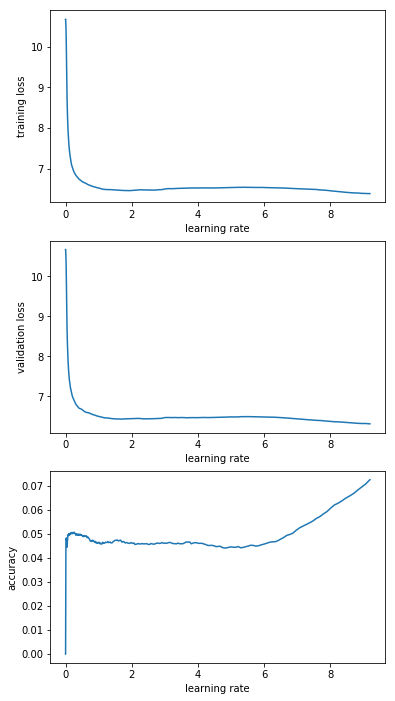

In [18]:
learner.sched.plot()

In [203]:
# Set learning rate
lr = 0.2

In [204]:
# we can load the trained model and re-train again
learner.load(f'wiki_{LANG}_1cycle_best')

In [205]:
learner.fit(lr, 1, wds=wd, cycle_len=15, use_clr=(10,33,0.95,0.85), best_save_name=f'wiki_{LANG}_1cycle_best')

epoch      trn_loss   val_loss   accuracy                                                                              
    0      2.510357   3.259221   0.439428  
    1      2.415729   3.260172   0.439824                                                                              
    2      2.375321   3.262639   0.439663                                                                              
    3      2.42159    3.25873    0.440174                                                                              
    4      2.43589    3.26199    0.439527                                                                              
    5      2.403028   3.263135   0.439833                                                                              
    6      2.516509   3.261539   0.43965                                                                               
    7      2.471415   3.266305   0.439269                                                                           

[3.2657493952229535, 0.44031678461238166]

In [222]:
print('Perplexity Score:')
np.exp(3.2657493952229535)

Perplexity Score:


26.19973759405871

In [206]:
learner.save(f'wiki_{LANG}_lm4')
learner.save_encoder(f'wiki_{LANG}_lm_enc4')

In [207]:
learner.load(f'wiki_{LANG}_lm4')
learner.load_encoder(f'wiki_{LANG}_lm_enc4')

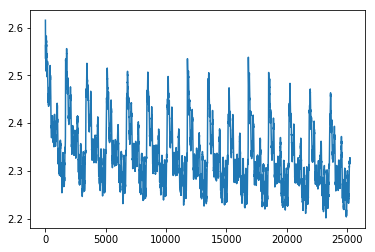

In [208]:
learner.sched.plot_loss()

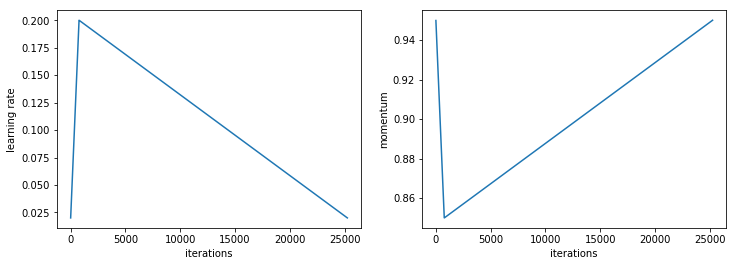

In [209]:
learner.sched.plot_lr()

In [210]:
learner.lr_find2(num_it=1000, end_lr=2)

 59%|███████████████████████████████████████▊                           | 1000/1683 [06:25<04:19,  2.63it/s, loss=2.69]

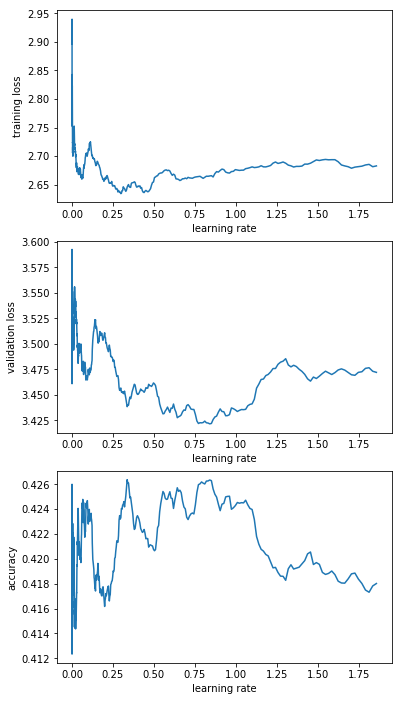

In [211]:
learner.sched.plot()

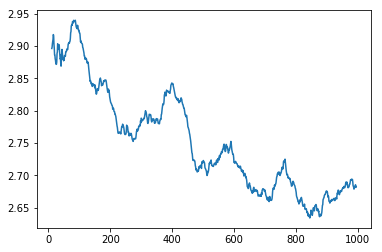

In [212]:
learner.sched.plot_loss()

# Generate sentence using the language model

In [213]:
LANG = 'tagalog'
LM_PATH = Path(f'{LANG}/')
LM_PATH_MODEL = f'models/wiki_{LANG}_lm4.h5'
LM_PATH_ITOS = f'wiki_{LANG}_itos.pkl'

In [214]:
itos = pickle.load(open(LM_PATH_ITOS, 'rb'))
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
vs = len(itos)
print("vs:", vs)

vs: 43006


In [215]:
m = learner.model # initialized model
m.eval() # ensure you switch your model to inference mode
m[0].bs = 1 # set batch size to 1

In [216]:
def gen_text(ss, topk):
    s = ss.strip().split(" ")
    t = LongTensor([stoi[i] for i in s]).view(-1, 1).cuda()
    t = Variable(t, volatile=False)
    m.reset()
    pred, *_ = m(t)
    pred_i = torch.topk(pred[-1], topk)[1]

    return [itos[o] for o in to_np(pred_i)]

def generate_sentences(ss, nb_words):
    result = []
    s = ss.strip().split(" ")
    t = LongTensor([stoi[i] for i in s]).view(-1, 1).cuda()
    t = Variable(t, volatile=False)
    m.reset()
    pred, *_ = m(t)
    
    for i in range(nb_words):
        pred_i = pred[-1].topk(2)[1]
        pred_i = pred_i[1] if pred_i.data[0] < 2 else pred_i[0]
        word = itos[pred_i.data[0]]
        if word != "xbos":
            result.append(word)
        else:
            break
        pred, *_ = m(pred_i.unsqueeze(0).unsqueeze(0))
    
    result = re.sub('\s+([.,])', r'\1', "{} {}".format(ss, " ".join(result).rstrip()))

    return(result)

In [217]:
strings = ["Pilipinas", 
           "Lalaki", 
           "Babae",
           "Diyos", 
           "Pampanga",
           "Agham",
           "Masaya",
           "Aso",
           "Rizal",
           "Quezon",
           "Kanina",
           "Manila"
           ]

In [218]:
import warnings
warnings.filterwarnings('ignore')
for s in strings:
    print(f"{s}... \n{generate_sentences(s.lower(), 80)}\n")

Pilipinas... 
pilipinas. 
 ang mga sumusunod ay ang mga dahilan ng kanilang mga pag - atake. ayon sa mga tala, ang mga pilipino ay dapat na magkaroon ng mga anak na lalaki sa isang paaralan o kolehiyo. ang mga ito ay mga opisyal na panuluyan ng mga pari, mga pari at mga pari. ang mga pari ay maaaring mag - alok ng mga pondo para sa kanilang mga layunin at mga gawain. ang mga mag

Lalaki... 
lalaki at babae. ang mga babae ay may mga pagkakataon na ang mga babae ay may mas mataas na antas ng sekswal na orientasyon kaysa sa mga babae. ang mga babae ay may mas mataas na antas ng pag - iisip kaysa sa mga babae. ang mga babae ay may mataas na antas ng pagiging lalaki at babae, at ang mga babae ay may mataas na pagiging pambabae, at ang mga babae ay may mas mataas

Babae... 
babae at babae. ang mga babae ay may mga pagkakataon na ang mga babae ay may mas mataas na antas ng sekswal na orientasyon kaysa sa mga babae. ang mga babae ay may mas mataas na antas ng pag - iisip kaysa sa mga babae. an

In [219]:
emb_weights = list(learner.model.named_parameters())[0][1]
emb_np = to_np(emb_weights.data)

In [220]:
tagalog2vec = pd.DataFrame(emb_np)
new_itos = itos
# replace space with token
new_itos[2] = '_space_'
# replace space for named entities with _
new_itos = [re.sub(' ', '_', i) for i in new_itos]
tagalog2vec.index = new_itos
tagalog2vec.iloc[200:210]

,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
sinasalita,-0.066267,-0.075203,0.088813,-0.313721,0.178212,-0.432431,-0.280485,-0.094527,-0.438331,0.677153,...,-0.030655,-0.111382,-0.265994,-0.039098,0.267049,0.082115,0.030402,0.161081,-0.247162,-0.175166
subalit,0.037091,0.142702,-0.319109,0.128350,-0.180885,0.255745,-0.276788,0.741796,0.082638,-0.465008,...,0.708428,-0.334420,0.218829,-0.531906,-0.165284,-0.125580,-0.244106,0.071785,-0.804260,0.083574
mayo,0.116198,0.127464,-0.066147,0.377194,-0.130793,-0.114470,0.231398,0.019844,0.513321,-0.002310,...,-0.275058,0.296505,-0.226319,0.038090,0.229367,0.367718,-0.104881,0.748504,-0.028562,-0.114035
mang,0.457836,-0.564047,0.390331,0.387986,0.097105,-0.384735,0.519472,0.224481,0.014166,0.317376,...,-0.353569,0.152376,-0.295674,0.661388,0.138340,0.340842,-0.326452,0.040575,-0.109441,-0.614512
pangkat,-0.356490,0.370588,0.180261,0.092619,0.209464,0.274397,-0.322093,0.272288,-0.545540,-0.005249,...,0.409589,0.411818,0.810894,0.042417,-0.527128,-0.070105,-0.042662,-0.328413,-0.033774,0.011785
di,-0.678381,-0.585457,0.163992,-0.709819,0.207512,-0.206647,-0.262033,0.269287,-0.776152,-0.023203,...,-0.410469,-0.093766,0.095009,-0.889230,-0.027779,0.027145,0.586352,-0.445743,-0.404172,0.173193
laban,-2.134453,0.127393,0.652921,-0.218276,0.447950,0.254326,-0.639207,0.018136,-0.928847,0.111395,...,-0.156787,-1.061052,0.259606,-0.309627,0.332482,0.031628,-0.195344,0.068816,0.380399,-0.107874
katawan,-0.296503,-0.291042,0.308367,-0.068543,0.347274,0.152191,-0.001920,-0.016047,-0.246977,-0.376914,...,-0.348480,-0.617272,0.504374,0.524752,0.182453,-0.136204,-0.218866,0.260726,0.000149,-0.003113
pagiging,-0.208041,-0.058364,0.171438,0.223040,-0.109464,-0.113379,0.029634,0.268582,0.153469,0.065295,...,-0.354835,0.081734,0.155162,0.042065,0.144922,-0.023899,-0.082450,0.255786,-0.344011,0.134261
higit,0.064602,-0.846375,0.293125,0.157340,0.200767,-0.168535,0.017808,1.047812,-0.509538,-0.644003,...,0.340615,0.299907,0.549921,0.340532,1.206987,0.086918,1.079353,0.245724,0.337828,0.805480


In [221]:

tagalog2vec.to_csv(f"{LM_PATH}/tagalog2vec_embeddings4.csv", sep=" ", header=False, line_terminator="\n")
tagalog2vec.shape

(43006, 400)